<h1>1. Library Import & Function Declare</h1>

In [4]:
#All the libraries needed to load
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
%matplotlib inline
from astropy import table #Just in case we need to deal with FITS file.
from functools import reduce

import warnings
warnings.filterwarnings("ignore")

import os
os.chdir('D:/SDSS/Data/MGS_DR8/')

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.mixture import GaussianMixture as GMM 
from sklearn.model_selection import train_test_split

In [2]:
#IQR Outlier Function
def IQR_outlier(data):
    percentile25 = data.quantile(0.25)
    percentile75 = data.quantile(0.75)
    
    IQR = percentile75 - percentile25
    
    Lower_bound = percentile25 - 1.5*IQR
    Upper_bound = percentile75 + 1.5*IQR
    return Lower_bound, Upper_bound

In [3]:
#Morphological Function
def SurfBrightness(Magnitude,AxisRatio_AB,Radius): #Mean Surface Brightness
    A = 2*(np.pi)*AxisRatio_AB*(Radius**2)
    B = 2.5*(np.log10(A))
    return Magnitude + B

def Size(Radius,AxisRatio_AB): #Galaxy Apparent Size
    return Radius*(np.sqrt(AxisRatio_AB))

def Elliptic(AxisRatio_AB): #Galaxy Apparent Ellipticity
    return np.sqrt(1-(AxisRatio_AB)**2)

def CIndex(PetroRad_90,PetroRad_50): #Concentration Index
    return PetroRad_90/PetroRad_50

def ShapeProb(lnLDev,lnLExp,fit): #Shape Probability
    A = lnLDev + lnLExp
    if fit == 'dev':
        return lnLDev/A
    elif fit == 'exp':
        return lnLExp/A
    else:
        return lnLDev/A

In [4]:
#ML Model Fitting Function (Poitn Estimate)
def modelFit(data_base, data_z, model, train_size, test_size, random_state):
    trainX = train_test_split(data_base, data_z, test_size = 0.50, train_size = 0.50, random_state=1)[0]
    testX = train_test_split(data_base, data_z, test_size = 0.50, train_size = 0.50, random_state=1)[1]
    trainZ = train_test_split(data_base, data_z, test_size = 0.50, train_size = 0.50, random_state=1)[2]
    testZ = train_test_split(data_base, data_z, test_size = 0.50, train_size = 0.50, random_state=1)[3]
    
    model.fit(trainX, trainZ)

    zSpec = testZ
    zPhoto = model.predict(testX)
    return zSpec, zPhoto

In [5]:
#Evaluation Metric Function
def Eval_metric(zSpec, zPhoto):
    RMSE = np.sqrt(np.mean(((zPhoto - zSpec)/(1 + zSpec))**2)) #Root-mean-squre error
    #print('RMSE: %6.4f' % RMSE)
    
    Out = np.sum(np.abs((zPhoto - zSpec)/(1 + zSpec)) > 0.15)/len(zSpec) 
    Outlier = 100.*Out #Outlier Fraction
    #print ('Outlier Fraction: %6.3f percent' % Outlier)
    
    Per68 = np.percentile((zPhoto - zSpec)/(1 + zSpec), 68) #68th Percentile Error
    #print ('68th Percentile: %6.4f' % Per68)
    
    StdDev = np.std((zPhoto - zSpec)/(1 + zSpec), ddof=1) #Standard Deviation
    #print ('Standard Deviation: %6.4f' % StdDev)
    
    NMAD = 1.48 * np.median(np.abs((zPhoto - zSpec)/(1 + zSpec))) #NMAD
    #print ('NMAD: %6.4f' % NMAD)
    
    bias = np.median(((zPhoto - zSpec)/(1 + zSpec)))
    sigbias = StdDev/np.sqrt(0.64*len(zPhoto))
    #print ('Median offset: %6.3f +/- %6.3f' % (bias,sigbias))
    
    return RMSE, Outlier, Per68, NMAD

In [6]:
#Point Estimate plot function using subplot method
def subplot_PE(i, j, zSpec, zPhoto, zRange, title):
    x = np.arange(0,zRange+0.05,0.05)
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((zPhoto - zSpec)/(1 + zSpec)) > 0.15
    notmask = ~mask
    
    #add lines to indicate outliers
    axs[i,j].plot(x, outlier_upper, 'k--')
    axs[i,j].plot(x, outlier_lower, 'k--')
    axs[i,j].plot(zSpec[mask], zPhoto[mask], 'r.', markersize=6,  alpha=0.5)
    axs[i,j].plot(zSpec[notmask], zPhoto[notmask], 'b.',  markersize=6, alpha=0.5)
    axs[i,j].plot(x, x, linewidth=1.5, color = 'red')
    axs[i,j].set_title(title)
    axs[i,j].set_xlim([x.min(), x.max()])
    axs[i,j].set_ylim([x.min(), x.max()])
    axs[i,j].set_xlabel('$zSpec$')
    axs[i,j].set_ylabel('$zPhoto$')
    axs[i,j].grid(alpha = 0.8)
    axs[i,j].tick_params(labelsize=15)

<h1>2. Data Loading & Cleaning</h1>

In [7]:
#Loading MGS Dataset
mgs = pd.read_csv('DR8_MGS.csv')
print(mgs.shape[0])
mgs.describe()

594735


objID     specObjID             ra            dec  \
count  5.947350e+05  5.947350e+05  594735.000000  594735.000000   
mean   1.237662e+18  1.633016e+18     181.966052      23.169546   
std    5.987472e+12  8.155193e+17      67.672218      19.226194   
min    1.237646e+18  2.994897e+17       0.000671     -11.252827   
25%    1.237658e+18  9.233394e+17     146.900750       6.713680   
50%    1.237662e+18  1.603431e+18     184.278101      21.031248   
75%    1.237665e+18  2.273347e+18     222.398491      37.674391   
max    1.237680e+18  3.723445e+18     359.999343      70.268945   

                   b              l      mode      type       zWarning  \
count  594735.000000  594735.000000  594735.0  594735.0  594735.000000   
mean       40.124749     154.021913       1.0       3.0       0.477594   
std        39.107265      92.655158       0.0       0.0       7.686605   
min       -74.028659       0.000428       1.0       3.0       0.000000   
25%        36.208394      67.035581       1.0       3.0       0.000000   
50%        52.137257     163.312088       1.0       3.0       0.000000   
75%        63.951658     216.400064       1.0       3.0       0.000000   
max        89.961872     359.999515       1.0       3.0     146.000000   

       sciencePrimary          zSpec       zSpecErr        velDisp  \
count        594735.0  594735.000000  594735.000000  594735.000000   
mean              1.0       0.112480       0.004325     135.700507   
std               0.0       0.114457       1.035545      80.275407   
min               1.0      -0.009978      -5.000000       0.000000   
25%               1.0       0.069021       0.000011      83.637105   
50%               1.0       0.102744       0.000019     132.525000   
75%               1.0       0.143012       0.000029     181.917850   
max               1.0       7.003870     600.803100     850.000000   

          velDispErr       snMedian       lnLDeV_u       lnLDeV_g  \
count  594735.000000  594735.000000  594735.000000  594735.000000   
mean       14.754465      15.287097     -22.378063    -555.468704   
std        16.561526       7.547665     273.280532    1567.724106   
min        -7.000000       0.000000  -45731.520000  -91568.770000   
25%         8.737545      10.400800      -9.709024    -494.360000   
50%        11.899530      13.782020      -3.502897    -116.996200   
75%        16.290950      18.441340      -1.139763     -20.178155   
max      1600.000000     101.189400       0.000000       0.000000   

            lnLDeV_r       lnLDeV_i       lnLDeV_z       lnLExp_u  \
count  594735.000000  594735.000000  594735.000000  594735.000000   
mean     -616.431834    -524.768287     -78.929550     -21.071596   
std      1596.219913    1346.679967     409.475587     198.750098   
min   -105042.200000 -104910.900000  -55607.380000  -45280.370000   
25%      -581.283650    -496.378950     -44.431780      -8.976710   
50%      -188.314800    -172.172700     -13.066550      -3.454717   
75%       -44.016275     -47.768810      -3.698555      -1.145322   
max         0.000000       0.000000       0.000000       0.000000   

            lnLExp_g       lnLExp_r       lnLExp_i       lnLExp_z  \
count  594735.000000  594735.000000  594735.000000  594735.000000   
mean     -826.443010   -1469.342355   -1501.781234    -298.491564   
std      2624.614167    3708.638981    3725.709677    1228.205730   
min    -81857.620000  -86694.240000  -85628.140000  -50547.750000   
25%      -533.009150   -1181.910000   -1235.945000    -159.269650   
50%      -177.397000    -457.714400    -487.436300     -48.133150   
75%       -62.647825    -139.582100    -142.815250     -10.190885   
max         0.000000       0.000000       0.000000       0.000000   

            deVMag_u       deVMag_g       deVMag_r       deVMag_i  \
count  594735.000000  594735.000000  594735.000000  594735.000000   
mean       19.095629      17.672159      16.964206      16.528029   
std        36.762491      34.379407    

In [8]:
#Deriving new morphological parameters
for i in ['i']:
    mgs['deVElip_{}'.format(i)] = Elliptic(mgs['deVAB_{}'.format(i)])
    mgs['expElip_{}'.format(i)] = Elliptic(mgs['expAB_{}'.format(i)])
    mgs['deVSize_{}'.format(i)] = Size(mgs['deVRad_{}'.format(i)], mgs['deVAB_{}'.format(i)])
    mgs['expSize_{}'.format(i)] = Size(mgs['expRad_{}'.format(i)], mgs['expAB_{}'.format(i)])
    mgs['deVMu_{}'.format(i)] = SurfBrightness(mgs['deVMag_{}'.format(i)], mgs['deVAB_{}'.format(i)], mgs['deVRad_{}'.format(i)])
    mgs['expMu_{}'.format(i)] = SurfBrightness(mgs['expMag_{}'.format(i)], mgs['expAB_{}'.format(i)], mgs['expRad_{}'.format(i)])
    mgs['CIndex_{}'.format(i)] = CIndex(mgs['petroR90_{}'.format(i)], mgs['petroR50_{}'.format(i)])
    mgs['deVP_{}'.format(i)] = ShapeProb(mgs['lnLDeV_{}'.format(i)], mgs['lnLExp_{}'.format(i)], fit='dev')
    mgs['expP_{}'.format(i)] = ShapeProb(mgs['lnLDeV_{}'.format(i)], mgs['lnLExp_{}'.format(i)], fit='exp')

In [9]:
#Remove rows which contains "not defined" values.
for col in mgs.columns[(mgs.min() == -9999.000000) | (mgs.min() == -9999.680000) | (mgs.min() == -9999.259000) | (mgs.min() == -9999.218000) | (mgs.min() == -9999.061000) | (mgs.min() == -1000.000000) | (mgs.min() == -9999.007000) | (mgs.min() == -9999.002000) | (mgs.min() == -10000.210000)]:
    mgs = mgs[mgs[col] > -99]

#Remove rows which contains -inf
for col in mgs.columns[mgs.min() == -np.inf]:
    mgs = mgs[(mgs[col] != -np.inf)]

#Remove rows with null values as well
mgs =  mgs.dropna()

#Keep only the "true" galaxies
mgs = mgs[(mgs['class'] == 'GALAXY') & (mgs['type'] == 3) & (mgs['zWarning'] == 0)]
mgs = mgs[(mgs['zSpec'] > 0) & (mgs['zSpec'] <= 0.3)]

#Perturbed photometry magnitude (From Newman)
for i in ['u', 'g', 'r', 'i', 'z']:
    mgs['pert_{}'.format(i)] = mgs['dered_{}'.format(i)] + np.sqrt(3)*mgs['err_{}'.format(i)]*np.random.randn(len(mgs['dered_{}'.format(i)]))

#Remove the following columns to save space.
mgs.drop(['mode', 'type', 'zWarning', 'sciencePrimary', 'lnLDeV_u', 'lnLDeV_g', 'lnLDeV_r', 'lnLDeV_z', 'lnLExp_u', 'lnLExp_g', 'lnLExp_r', 
          'lnLExp_z', 'deVAB_u', 'deVAB_g', 'deVAB_r', 'deVAB_z', 'deVABErr_u', 'deVABErr_g', 'deVABErr_r', 'deVABErr_z', 'deVRad_u', 
          'deVRad_g', 'deVRad_r', 'deVRad_z', 'deVRadErr_u', 'deVRadErr_g', 'deVRadErr_r', 'deVRadErr_z', 'expRad_u', 'expRad_g', 
          'expRad_r', 'expRad_z', 'expRadErr_u', 'expRadErr_g', 'expRadErr_r', 'expRadErr_z', 'petroRad_u', 'petroRad_g', 'petroRad_r', 
          'petroRad_z', 'petroRadErr_u', 'petroRadErr_g', 'petroRadErr_r', 'petroRadErr_z', 'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_z', 
          'petroR50Err_u', 'petroR50Err_g', 'petroR50Err_r', 'petroR50Err_z', 'petroR90_u', 'petroR90_g', 'petroR90_r', 'petroR90_z', 
          'petroR90Err_u', 'petroR90Err_g', 'petroR90Err_r', 'petroR90Err_z', 'expAB_u', 'expAB_g', 'expAB_r', 'expAB_z', 'expABErr_u', 
          'expABErr_g', 'expABErr_r', 'expABErr_z', 'fracDeV_u', 'fracDeV_g', 'fracDeV_r', 'fracDeV_z', 'q_u', 'q_g', 'q_r', 'q_z', 'qErr_u', 
          'qErr_g', 'qErr_r', 'qErr_z', 'u_u', 'u_g', 'u_r', 'u_z', 'uErr_u', 'uErr_g', 'uErr_r', 'uErr_z', 'petroMag_u', 'petroMag_g', 'petroMag_r', 
          'petroMag_z', 'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_z','psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 
          'psfMagErr_u', 'psfMagErr_g', 'psfMagErr_r', 'psfMagErr_i', 'psfMagErr_z','deVPhi_u', 'deVPhi_g', 'deVPhi_r', 'deVPhi_z'], 
         axis=1, inplace=True)

print(mgs.shape[0])
mgs.describe()

287423


objID     specObjID             ra            dec  \
count  2.874230e+05  2.874230e+05  287423.000000  287423.000000   
mean   1.237661e+18  1.649797e+18     183.616055      25.038565   
std    5.878829e+12  8.233933e+17      59.365103      18.840323   
min    1.237646e+18  2.994897e+17       0.000671     -11.244277   
25%    1.237658e+18  9.459236e+17     151.762456       9.433694   
50%    1.237662e+18  1.607906e+18     184.907426      23.985064   
75%    1.237665e+18  2.351038e+18     220.040138      39.314303   
max    1.237680e+18  3.348600e+18     359.995927      70.268945   

                   b              l          zSpec       zSpecErr  \
count  287423.000000  287423.000000  287423.000000  287423.000000   
mean       45.851011     155.580165       0.085814       0.000011   
std        33.934710      92.801027       0.041611       0.001865   
min       -74.028383       0.000573       0.000014      -1.000000   
25%        40.469766      70.113716       0.055823       0.000009   
50%        54.381763     163.808981       0.079958       0.000013   
75%        65.158425     218.449139       0.110956       0.000019   
max        89.961872     359.999515       0.299943       0.000166   

             velDisp     velDispErr       snMedian      lnLDeV_i  \
count  287423.000000  287423.000000  287423.000000  2.874230e+05   
mean      115.690244      14.024122      17.509438 -8.191686e+02   
std        65.554625      15.234317       8.189335  1.621887e+03   
min         0.000000      -3.000000       1.116749 -6.649869e+04   
25%        72.098365       7.703333      11.610225 -8.409098e+02   
50%       109.811400      10.910070      15.743890 -3.611738e+02   
75%       153.441700      15.988210      21.584270 -1.326610e+02   
max       850.000000    1306.395000      90.919050 -5.045386e-11   

           lnLExp_i       deVMag_u       deVMag_g       deVMag_r  \
count  2.874230e+05  287423.000000  287423.000000  287423.000000   
mean  -2.113246e+03      18.624692      17.282614      16.589396   
std    4.835891e+03       0.973221       0.871305       0.846793   
min   -8.562814e+04      13.320450      11.523490      10.696500   
25%   -1.900671e+03      18.063215      16.825120      16.148100   
50%   -5.264438e+02      18.697700      17.434430      16.759660   
75%   -1.213201e+02      19.263765      17.884675      17.203800   
max   -6.884943e-09      24.262140      21.149160      19.895870   

            deVMag_i       deVMag_z    deVMagErr_u    deVMagErr_g  \
count  287423.000000  287423.000000  287423.000000  287423.000000   
mean       16.225638      15.975032       0.045553       0.006898   
std         0.852321       0.876186       0.029029       0.002800   
min        10.241110       9.973405       0.002434       0.001477   
25%        15.780630      15.514370       0.029837       0.005063   
50%        16.399450      16.145410       0.042009       0.006647   
75%        16.846780      16.610140       0.055308       0.008331   
max        19.779640      19.783780       7.020902       0.087670   

         deVMagErr_r    deVMagErr_i    deVMagErr_z   extinction_u  \
count  287423.000000  287423.000000  287423.000000  287423.000000   
mean        0.005631       0.005903       0.014861       0.157149   
std         0.002478       0.002817       0.010271       0.101695   
min         0.001456       0.001445       0.001560       0.015635   
25%         0.004072       0.004103       0.008650       0.091015   
50%         0.005365       0.005460       0.012795       0.133655   
75%         0.006802       0.007071       0.018578       0.195628   
max         0.470700       0.128970       2.038781       5.879971   

        extinction_g   extinction_r   extinction_i   extinction_z  \
count  287423.000000  287423.000000  287423.000000  287423.000000   
mean        0.115629       0.083864       0.063591       0.045087   
std         0.074826       0.054270       0.041151       0.029177   
min         0.011504       0.008343       

<h1>3. Exploratory Data Analysis</h1>

In [10]:
fig, axs = plt.subplots(2,3,figsize=(14,7), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Distribution of Band Magnitude', fontsize=20)
#axs[1,2].set_visible(False)

axs[0,0].hist(mgs['dered_u'], 50, density=False, histtype='step', alpha=0.75, label='dereddened')
axs[0,0].hist(mgs['pert_u'], 50, density=False, histtype='step', alpha=0.75, label='perturbed')
axs[0,0].set_title('U Band')
axs[0,0].legend(loc='upper left')
axs[0,0].set_ylabel('Count')

axs[0,1].hist(mgs['dered_g'], 50, density=False, histtype='step', alpha=0.75, label='dereddened')
axs[0,1].hist(mgs['pert_g'], 50, density=False, histtype='step', alpha=0.75, label='perturbed')
axs[0,1].set_title('G Band')

axs[0,2].hist(mgs['dered_r'], 50, density=False, histtype='step', alpha=0.75, label='dereddened')
axs[0,2].hist(mgs['pert_r'], 50, density=False, histtype='step', alpha=0.75, label='perturbed')
axs[0,2].set_title('R Band')

axs[1,0].hist(mgs['dered_i'], 50, density=False, histtype='step', alpha=0.75, label='dereddened')
axs[1,0].hist(mgs['pert_i'], 50, density=False, histtype='step', alpha=0.75, label='perturbed')
axs[1,0].set_title('I Band')
axs[1,0].set_ylabel('Count')
axs[1,0].set_xlabel('Magnitude')

axs[1,1].hist(mgs['dered_z'], 50, density=False, histtype='step', alpha=0.75, label='dereddened')
axs[1,1].hist(mgs['pert_z'], 50, density=False, histtype='step', alpha=0.75, label='perturbed')
axs[1,1].set_title('Z Band')
axs[1,1].set_xlabel('Magnitude')

axs[1,2].hist(mgs['dered_u'], 50, density=False, histtype='stepfilled', alpha=0.3, label='U')
axs[1,2].hist(mgs['dered_g'], 50, density=False, histtype='stepfilled', alpha=0.3, label='G')
axs[1,2].hist(mgs['dered_r'], 50, density=False, histtype='stepfilled', alpha=0.3, label='R')
axs[1,2].hist(mgs['dered_i'], 50, density=False, histtype='stepfilled', alpha=0.3, label='I')
axs[1,2].hist(mgs['dered_z'], 50, density=False, histtype='stepfilled', alpha=0.3, label='Z')
axs[1,2].set_title('Overall')
axs[1,2].legend(loc='upper left')
axs[1,2].set_xlim(12, 22)
axs[1,2].set_xlabel('Magnitude')

Text(0.5, 0, 'Magnitude')

In [11]:
fig, axs = plt.subplots(2,3,figsize=(14,7), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Spec-Z Distribution (Based on Band Magnitude)', fontsize=20)
#axs[1,2].set_visible(False)

axs[0,0].hist(mgs['zSpec'], 50, density=False, histtype='step', alpha=0.75)
axs[0,0].set_title('Overall')
axs[0,0].set_ylabel('Count')

axs[0,1].hist(mgs[mgs['dered_u'] < 12]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='<12')
axs[0,1].hist(mgs[(mgs['dered_u'] >= 12) & (mgs['dered_u'] < 14)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='12-14')
axs[0,1].hist(mgs[(mgs['dered_u'] >= 14) & (mgs['dered_u'] < 16)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='14-16')
axs[0,1].hist(mgs[(mgs['dered_u'] >= 16) & (mgs['dered_u'] < 18)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='16-18')
axs[0,1].hist(mgs[(mgs['dered_u'] >= 18) & (mgs['dered_u'] < 20)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='18-20')
axs[0,1].hist(mgs[(mgs['dered_u'] >= 20) & (mgs['dered_u'] < 22)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='20-22')
axs[0,1].hist(mgs[(mgs['dered_u'] >= 22) & (mgs['dered_u'] < 24)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='22-24')
axs[0,1].hist(mgs[mgs['dered_u'] >= 24]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='>24')
axs[0,1].legend(loc='upper right')
axs[0,1].set_xlim(0, 0.3)
axs[0,1].set_title('Magnitude: U Band')

axs[0,2].hist(mgs[mgs['dered_g'] < 12]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='<12')
axs[0,2].hist(mgs[(mgs['dered_g'] >= 12) & (mgs['dered_g'] < 14)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='12-14')
axs[0,2].hist(mgs[(mgs['dered_g'] >= 14) & (mgs['dered_g'] < 16)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='14-16')
axs[0,2].hist(mgs[(mgs['dered_g'] >= 16) & (mgs['dered_g'] < 18)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='16-18')
axs[0,2].hist(mgs[(mgs['dered_g'] >= 18) & (mgs['dered_g'] < 20)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='18-20')
axs[0,2].hist(mgs[mgs['dered_g'] >= 20]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='>20')
#axs[0,2].legend(loc='upper right')
axs[0,2].set_xlim(0, 0.3)
axs[0,2].set_title('Magnitude: G Band')

axs[1,0].hist(mgs[mgs['dered_r'] < 12]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='<12')
axs[1,0].hist(mgs[(mgs['dered_r'] >= 12) & (mgs['dered_r'] < 14)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='12-14')
axs[1,0].hist(mgs[(mgs['dered_r'] >= 14) & (mgs['dered_r'] < 16)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='14-16')
axs[1,0].hist(mgs[(mgs['dered_r'] >= 16) & (mgs['dered_r'] < 18)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='16-18')
axs[1,0].hist(mgs[mgs['dered_r'] >= 18]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='>18')
#axs[1,0].legend(loc='upper right')
axs[1,0].set_xlim(0, 0.3)
axs[1,0].set_xlabel('Redshift')
axs[1,0].set_ylabel('Count')
axs[1,0].set_title('Magnitude: R Band')

axs[1,1].hist(mgs[mgs['dered_i'] < 12]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='<12')
axs[1,1].hist(mgs[(mgs['dered_i'] >= 12) & (mgs['dered_i'] < 14)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='12-14')
axs[1,1].hist(mgs[(mgs['dered_i'] >= 14) & (mgs['dered_i'] < 16)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='14-16')
axs[1,1].hist(mgs[(mgs['dered_i'] >= 16) & (mgs['dered_i'] < 18)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='16-18')
axs[1,1].hist(mgs[mgs['dered_i'] >= 18]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='>18')
#axs[1,1].legend(loc='upper right')
axs[1,1].set_xlim(0, 0.3)
axs[1,1].set_xlabel('Redshift')
axs[1,1].set_title('Magnitude: I Band')

axs[1,2].hist(mgs[mgs['dered_z'] < 12]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='<12')
axs[1,2].hist(mgs[(mgs['dered_z'] >= 12) & (mgs['dered_z'] < 14)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='12-14')
axs[1,2].hist(mgs[(mgs['dered_z'] >= 14) & (mgs['dered_z'] < 16)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='14-16')
axs[1,2].hist(mgs[(mgs['dered_z'] >= 16) & (mgs['dered_z'] < 18)]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='16-18')
axs[1,2].hist(mgs[mgs['dered_z'] >= 18]['zSpec'], 50, density=False, histtype='step', alpha=0.75, label='>18')
#axs[1,2].legend(loc='upper right')
axs[1,2].set_xlim(0, 0.3)
axs[1,2].set_xlabel('Redshift')
axs[1,2].set_title('Magnitude: Z Band')

Text(0.5, 1.0, 'Magnitude: Z Band')

In [12]:
fig, axs = plt.subplots(3,3,figsize=(14,11), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Spec-Z Distribution (Based on Band Magnitude)', fontsize=20)
axs[0,0].set_visible(False)
axs[0,2].set_visible(False)

axs[0,1].plot(mgs['zSpec'], mgs['dered_i'], 'bo', markersize=0.4, alpha=0.75, label='Dered')
axs[0,1].plot(mgs['zSpec'], mgs['deVMag_i'], 'ro', markersize=0.4, alpha=0.75, label='DeV')
axs[0,1].plot(mgs['zSpec'], mgs['expMag_i'], 'ko', markersize=0.4, alpha=0.75, label='Exp')
axs[0,1].plot(mgs['zSpec'], mgs['petroMag_i'], 'go', markersize=0.4, alpha=0.75, label='Petro')
axs[0,1].legend(loc='lower right')
axs[0,1].set_title('I Magnitude vs Redshift')
axs[0,1].set_ylabel('I Magnitude')
axs[0,1].set_xlabel('Redshift')

axs[1,0].plot(mgs['dered_i'], mgs['deVMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.4f}".format(Eval_metric(mgs['dered_i'], 
                                                                                                                         mgs['deVMag_i'])[0]))) #RMSE
axs[1,0].plot(mgs['dered_i'], mgs['deVMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.6f}".format(Eval_metric(mgs['dered_i'], 
                                                                                                                         mgs['deVMag_i'])[1]))) #68th Percentile
axs[1,0].legend(loc='lower right')
axs[1,0].set_title('DeVaucouler vs Dered')
axs[1,0].set_ylabel('Mag (DeV)')
axs[1,0].set_xlabel('Mag (Dered)')

axs[1,1].plot(mgs['dered_i'], mgs['expMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.4f}".format(Eval_metric(mgs['dered_i'], 
                                                                                                                         mgs['expMag_i'])[0]))) #RMSE
axs[1,1].plot(mgs['dered_i'], mgs['expMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.6f}".format(Eval_metric(mgs['dered_i'], 
                                                                                                                         mgs['expMag_i'])[1]))) #68th Percentile
axs[1,1].legend(loc='lower right')
axs[1,1].set_title('Exponential vs Dered')
axs[1,1].set_ylabel('Mag (Exp)')
axs[1,1].set_xlabel('Mag (Dered)')

axs[1,2].plot(mgs['dered_i'], mgs['petroMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.4f}".format(Eval_metric(mgs['dered_i'], 
                                                                                                                         mgs['petroMag_i'])[0]))) #RMSE
axs[1,2].plot(mgs['dered_i'], mgs['petroMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.6f}".format(Eval_metric(mgs['dered_i'], 
                                                                                                                         mgs['petroMag_i'])[1]))) #68th Percentile
axs[1,2].legend(loc='lower right')
axs[1,2].set_title('Petrosian vs Dered')
axs[1,2].set_ylabel('Mag (Petro)')
axs[1,2].set_xlabel('Mag (Dered)')

axs[2,0].plot(mgs['deVMag_i'], mgs['expMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.4f}".format(Eval_metric(mgs['deVMag_i'], 
                                                                                                                          mgs['expMag_i'])[0]))) #RMSE
axs[2,0].plot(mgs['deVMag_i'], mgs['expMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.6f}".format(Eval_metric(mgs['deVMag_i'], 
                                                                                                                          mgs['expMag_i'])[1]))) #68th Percentile
axs[2,0].legend(loc='lower right')
axs[2,0].set_title('DeVaucouler vs Exponential')
axs[2,0].set_ylabel('Mag (Exp)')
axs[2,0].set_xlabel('Mag (DeV)')

axs[2,1].plot(mgs['deVMag_i'], mgs['petroMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.4f}".format(Eval_metric(mgs['deVMag_i'], 
                                                                                                                            mgs['petroMag_i'])[0]))) #RMSE
axs[2,1].plot(mgs['deVMag_i'], mgs['petroMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.6f}".format(Eval_metric(mgs['deVMag_i'], 
                                                                                                                            mgs['petroMag_i'])[1]))) #68th Percentile
axs[2,1].legend(loc='lower right')
axs[2,1].set_title('DeVaucouler vs Petrosian')
axs[2,1].set_ylabel('Mag (Petro)')
axs[2,1].set_xlabel('Mag (DeV)')

axs[2,2].plot(mgs['expMag_i'], mgs['petroMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.4f}".format(Eval_metric(mgs['expMag_i'], 
                                                                                                                            mgs['petroMag_i'])[0]))) #RMSE
axs[2,2].plot(mgs['expMag_i'], mgs['petroMag_i'], 'bo', markersize=0.4, alpha=0.75, label=float("{:.6f}".format(Eval_metric(mgs['expMag_i'], 
                                                                                                                            mgs['petroMag_i'])[1]))) #68th Percentile
axs[2,2].legend(loc='lower right')
axs[2,2].set_title('Exponential vs Petrosian')
axs[2,2].set_ylabel('Mag (Petro)')
axs[2,2].set_xlabel('Mag (Exp)')

Text(0.5, 0, 'Mag (Exp)')

<h2>A. Effect on photo-z estimation when number of bands decreases</h2>

In [13]:
## UGRIZ, GRI, I
#UGRIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_UGRIZ, zPhoto_UGRIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ, Outlier_UGRIZ, Perc68_UGRIZ, NMAD_UGRIZ = Eval_metric(zSpec_UGRIZ, zPhoto_UGRIZ)

#GRI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_r', 'dered_i']])
model = RandomForestRegressor()
zSpec_GRI, zPhoto_GRI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GRI, Outlier_GRI, Perc68_GRI, NMAD_GRI = Eval_metric(zSpec_GRI, zPhoto_GRI)

#I
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i']])
model = RandomForestRegressor()
zSpec_I, zPhoto_I = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I, Outlier_I, Perc68_I, NMAD_I = Eval_metric(zSpec_I, zPhoto_I)

In [14]:
#Plotting Point Estimate for UGRIZ, GRI, I
fig, axs = plt.subplots(3, 3, figsize=(14,14), tight_layout=True, sharex=False, sharey=False)
axs[1,0].set_visible(False)
axs[1,1].set_visible(False)
axs[1,2].set_visible(False)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_UGRIZ, zPhoto_UGRIZ, zRange=0.3, title='UGRIZ')
subplot_PE(0, 1, zSpec_GRI, zPhoto_GRI, zRange=0.3, title='GRI')
subplot_PE(0, 2, zSpec_I, zPhoto_I, zRange=0.3, title='I')

In [15]:
#Summary Statistics
data = [['UGRIZ', RMSE_UGRIZ, Outlier_UGRIZ, Perc68_UGRIZ, NMAD_UGRIZ], 
        ['GRI', RMSE_GRI, Outlier_GRI, Perc68_GRI, NMAD_GRI], 
        ['I', RMSE_I, Outlier_I, Perc68_I, NMAD_I]]
Sum = pd.DataFrame(data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

In [16]:
#Plotting Summary Statistics
fig, axs = plt.subplots(2, 2, figsize=(14,7), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Summary Statistics: Decrease in Number of Bands', fontsize=15)

axs[0,0].scatter(Sum['Condition'], Sum['RMSE'])
axs[0,0].axhline(y = RMSE_UGRIZ, color = 'k', linestyle = '--')
axs[0,0].set_ylabel('RMSE')
axs[0,1].scatter(Sum['Condition'], Sum['Outlier'])
axs[0,1].axhline(y = Outlier_UGRIZ, color = 'k', linestyle = '--')
axs[0,1].set_ylabel('Outlier Fraction (%)')
axs[1,0].scatter(Sum['Condition'], Sum['68th'])
axs[1,0].axhline(y = Perc68_UGRIZ, color = 'k', linestyle = '--')
axs[1,0].set_ylabel('68th Percentile')
axs[1,1].scatter(Sum['Condition'], Sum['NMAD'])
axs[1,1].axhline(y = NMAD_UGRIZ, color = 'k', linestyle = '--')
axs[1,1].set_ylabel('NMAD')

Text(0, 0.5, 'NMAD')

<h2>B. Effects on photo-z estimation when error informations are included</h2>

In [17]:
## MAGNITUDE ONLY
# U-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u']])
model = RandomForestRegressor()
zSpec_Umag, zPhoto_Umag = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Umag, Outlier_Umag, Perc68_Umag, NMAD_Umag = Eval_metric(zSpec_Umag, zPhoto_Umag)

# G-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g']])
model = RandomForestRegressor()
zSpec_Gmag, zPhoto_Gmag = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Gmag, Outlier_Gmag, Perc68_Gmag, NMAD_Gmag = Eval_metric(zSpec_Gmag, zPhoto_Gmag)

# R-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_r']])
model = RandomForestRegressor()
zSpec_Rmag, zPhoto_Rmag = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Rmag, Outlier_Rmag, Perc68_Rmag, NMAD_Rmag = Eval_metric(zSpec_Rmag, zPhoto_Rmag)

# I-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i']])
model = RandomForestRegressor()
zSpec_Imag, zPhoto_Imag = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Imag, Outlier_Imag, Perc68_Imag, NMAD_Imag = Eval_metric(zSpec_Imag, zPhoto_Imag)

# Z-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_z']])
model = RandomForestRegressor()
zSpec_Zmag, zPhoto_Zmag = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Zmag, Outlier_Zmag, Perc68_Zmag, NMAD_Zmag = Eval_metric(zSpec_Zmag, zPhoto_Zmag)

# UGRIZ-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_UGRIZmag, zPhoto_UGRIZmag = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZmag, Outlier_UGRIZmag, Perc68_UGRIZmag, NMAD_UGRIZmag = Eval_metric(zSpec_UGRIZmag, zPhoto_UGRIZmag)

## MAGNITUDE + ERRORS
# U-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'err_u']])
model = RandomForestRegressor()
zSpec_Umage, zPhoto_Umage = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Umage, Outlier_Umage, Perc68_Umage, NMAD_Umage = Eval_metric(zSpec_Umage, zPhoto_Umage)

# G-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'err_g']])
model = RandomForestRegressor()
zSpec_Gmage, zPhoto_Gmage = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Gmage, Outlier_Gmage, Perc68_Gmage, NMAD_Gmage = Eval_metric(zSpec_Gmage, zPhoto_Gmage)

# R-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_r', 'err_r']])
model = RandomForestRegressor()
zSpec_Rmage, zPhoto_Rmage = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Rmage, Outlier_Rmage, Perc68_Rmage, NMAD_Rmage = Eval_metric(zSpec_Rmage, zPhoto_Rmage)

# I-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'err_i']])
model = RandomForestRegressor()
zSpec_Image, zPhoto_Image = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Image, Outlier_Image, Perc68_Image, NMAD_Image = Eval_metric(zSpec_Image, zPhoto_Image)

# Z-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_z', 'err_z']])
model = RandomForestRegressor()
zSpec_Zmage, zPhoto_Zmage = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Zmage, Outlier_Zmage, Perc68_Zmage, NMAD_Zmage = Eval_metric(zSpec_Zmage, zPhoto_Zmage)

# UGRIZ-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'err_u', 'dered_g', 'err_g', 'dered_r', 'err_r', 'dered_i', 'err_i', 'dered_z', 'err_z']])
model = RandomForestRegressor()
zSpec_UGRIZmage, zPhoto_UGRIZmage = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZmage, Outlier_UGRIZmage, Perc68_UGRIZmage, NMAD_UGRIZmage = Eval_metric(zSpec_UGRIZmage, zPhoto_UGRIZmage)

## PERTURBED MAGNITUDE
# U-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['pert_u']])
model = RandomForestRegressor()
zSpec_Upert, zPhoto_Upert = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Upert, Outlier_Upert, Perc68_Upert, NMAD_Upert = Eval_metric(zSpec_Upert, zPhoto_Upert)

# G-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['pert_g']])
model = RandomForestRegressor()
zSpec_Gpert, zPhoto_Gpert = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Gpert, Outlier_Gpert, Perc68_Gpert, NMAD_Gpert = Eval_metric(zSpec_Gpert, zPhoto_Gpert)

# R-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['pert_r']])
model = RandomForestRegressor()
zSpec_Rpert, zPhoto_Rpert = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Rpert, Outlier_Rpert, Perc68_Rpert, NMAD_Rpert = Eval_metric(zSpec_Rpert, zPhoto_Rpert)

# I-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['pert_i']])
model = RandomForestRegressor()
zSpec_Ipert, zPhoto_Ipert = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Ipert, Outlier_Ipert, Perc68_Ipert, NMAD_Ipert = Eval_metric(zSpec_Ipert, zPhoto_Ipert)

# Z-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['pert_z']])
model = RandomForestRegressor()
zSpec_Zpert, zPhoto_Zpert = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Zpert, Outlier_Zpert, Perc68_Zpert, NMAD_Zpert = Eval_metric(zSpec_Zpert, zPhoto_Zpert)

# UGRIZ-Band
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['pert_u', 'pert_g', 'pert_r', 'pert_i', 'pert_z']])
model = RandomForestRegressor()
zSpec_UGRIZpert, zPhoto_UGRIZpert = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZpert, Outlier_UGRIZpert, Perc68_UGRIZpert, NMAD_UGRIZpert = Eval_metric(zSpec_UGRIZpert, zPhoto_UGRIZpert)

In [18]:
## MAGNITUDE ONLY
fig, axs = plt.subplots(3, 3, figsize=(14,14), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Magnitude Only', fontsize=20)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_Umag, zPhoto_Umag, zRange=0.3, title='U-Band')
subplot_PE(0, 1, zSpec_Gmag, zPhoto_Gmag, zRange=0.3, title='G-Band')
subplot_PE(0, 2, zSpec_Rmag, zPhoto_Gmag, zRange=0.3, title='R-Band')
subplot_PE(1, 0, zSpec_Imag, zPhoto_Imag, zRange=0.3, title='I-Band')
subplot_PE(1, 1, zSpec_Zmag, zPhoto_Zmag, zRange=0.3, title='Z-Band')
subplot_PE(1, 2, zSpec_UGRIZmag, zPhoto_UGRIZmag, zRange=0.3, title='UGRIZ')

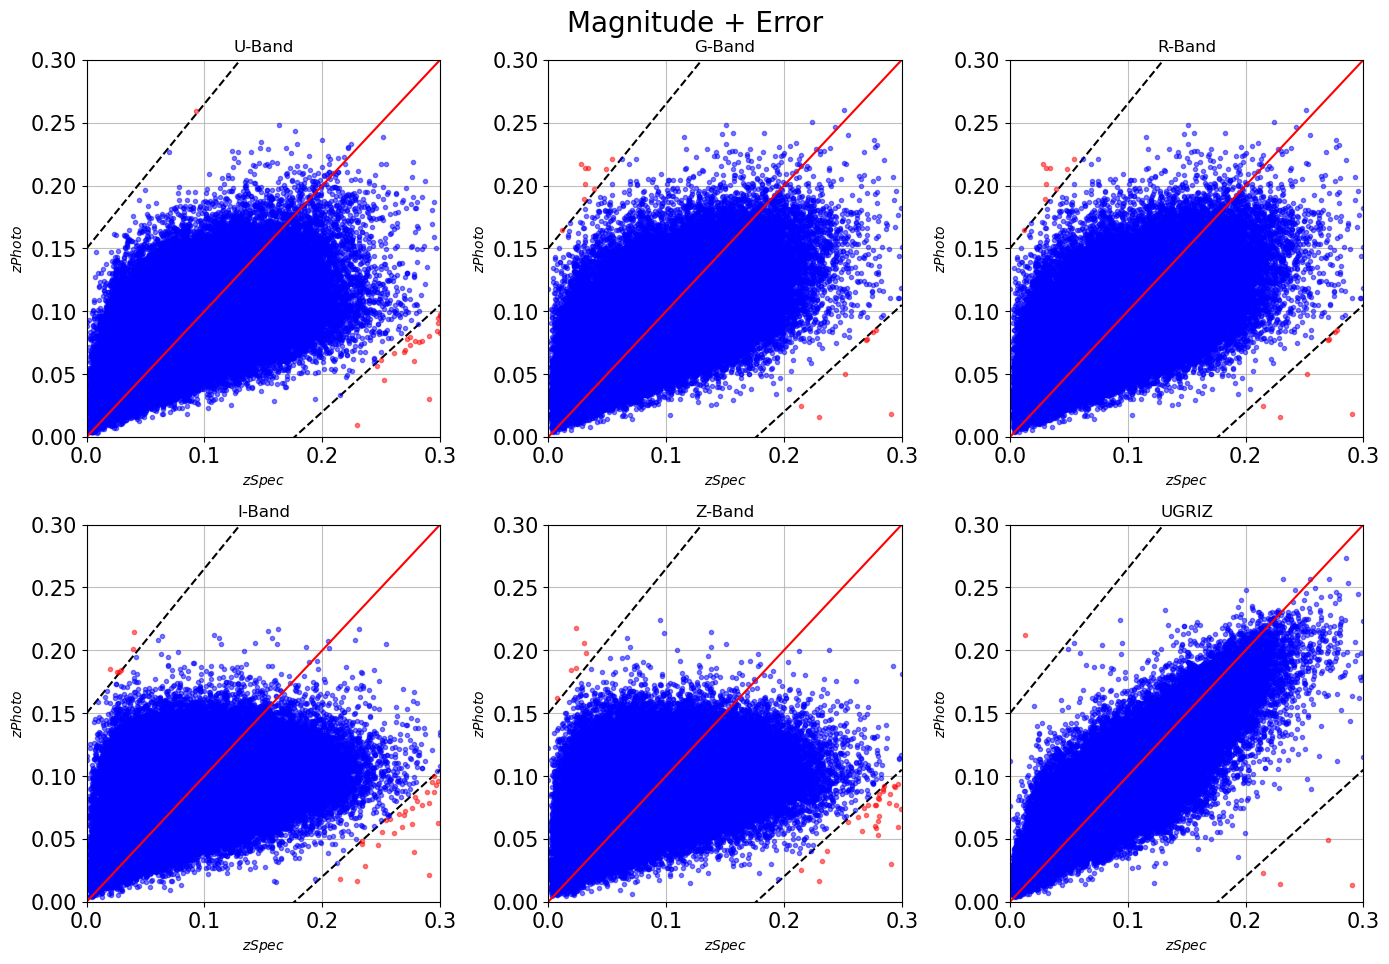

In [19]:
## MAGNITUDE + ERRORS
fig, axs = plt.subplots(3, 3, figsize=(14,14), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Magnitude + Error', fontsize=20)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_Umage, zPhoto_Umage, zRange=0.3, title='U-Band')
subplot_PE(0, 1, zSpec_Gmage, zPhoto_Gmage, zRange=0.3, title='G-Band')
subplot_PE(0, 2, zSpec_Rmage, zPhoto_Gmage, zRange=0.3, title='R-Band')
subplot_PE(1, 0, zSpec_Image, zPhoto_Image, zRange=0.3, title='I-Band')
subplot_PE(1, 1, zSpec_Zmage, zPhoto_Zmage, zRange=0.3, title='Z-Band')
subplot_PE(1, 2, zSpec_UGRIZmage, zPhoto_UGRIZmage, zRange=0.3, title='UGRIZ')

In [20]:
## PERTURBED MAGNITUDE
fig, axs = plt.subplots(3, 3, figsize=(14,14), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Perturbed Magnitude', fontsize=20)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_Upert, zPhoto_Upert, zRange=0.3, title='U-Band')
subplot_PE(0, 1, zSpec_Gpert, zPhoto_Gpert, zRange=0.3, title='G-Band')
subplot_PE(0, 2, zSpec_Rpert, zPhoto_Rpert, zRange=0.3, title='R-Band')
subplot_PE(1, 0, zSpec_Ipert, zPhoto_Ipert, zRange=0.3, title='I-Band')
subplot_PE(1, 1, zSpec_Zpert, zPhoto_Zpert, zRange=0.3, title='Z-Band')
subplot_PE(1, 2, zSpec_UGRIZpert, zPhoto_UGRIZpert, zRange=0.3, title='UGRIZ')

In [21]:
## Initialize list of lists & Create the pandas DataFrame
#U-band
U_data = [['Magnitude', RMSE_Umag, Outlier_Umag, Perc68_Umag, NMAD_Umag], 
        ['Magnitude+Error', RMSE_Umage, Outlier_Umage, Perc68_Umage, NMAD_Umage], 
        ['Perturbed', RMSE_Upert, Outlier_Upert, Perc68_Upert, NMAD_Upert]]
U_Sum = pd.DataFrame(U_data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

#G-band
G_data = [['Magnitude', RMSE_Gmag, Outlier_Gmag, Perc68_Gmag, NMAD_Gmag], 
        ['Magnitude+Error', RMSE_Gmage, Outlier_Gmage, Perc68_Gmage, NMAD_Gmage], 
        ['Perturbed', RMSE_Gpert, Outlier_Gpert, Perc68_Gpert, NMAD_Gpert]]
G_Sum = pd.DataFrame(G_data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

#R-band
R_data = [['Magnitude', RMSE_Rmag, Outlier_Rmag, Perc68_Rmag, NMAD_Rmag], 
        ['Magnitude+Error', RMSE_Rmage, Outlier_Rmage, Perc68_Rmage, NMAD_Rmage], 
        ['Perturbed', RMSE_Rpert, Outlier_Rpert, Perc68_Rpert, NMAD_Rpert]]
R_Sum = pd.DataFrame(R_data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

#I-band
I_data = [['Magnitude', RMSE_Imag, Outlier_Imag, Perc68_Imag, NMAD_Imag], 
        ['Magnitude+Error', RMSE_Image, Outlier_Image, Perc68_Image, NMAD_Image], 
        ['Perturbed', RMSE_Ipert, Outlier_Ipert, Perc68_Ipert, NMAD_Ipert]]
I_Sum = pd.DataFrame(I_data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

#Z-band
Z_data = [['Magnitude', RMSE_Zmag, Outlier_Zmag, Perc68_Zmag, NMAD_Zmag], 
        ['Magnitude+Error', RMSE_Zmage, Outlier_Zmage, Perc68_Zmage, NMAD_Zmage], 
        ['Perturbed', RMSE_Zpert, Outlier_Zpert, Perc68_Zpert, NMAD_Zpert]]
Z_Sum = pd.DataFrame(Z_data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

#UGRIZ
UGRIZ_data = [['Magnitude', RMSE_UGRIZmag, Outlier_UGRIZmag, Perc68_UGRIZmag, NMAD_UGRIZmag], 
        ['Magnitude+Error', RMSE_UGRIZmage, Outlier_UGRIZmage, Perc68_UGRIZmage, NMAD_UGRIZmage], 
        ['Perturbed', RMSE_UGRIZpert, Outlier_UGRIZpert, Perc68_UGRIZpert, NMAD_UGRIZpert]]
UGRIZ_Sum = pd.DataFrame(UGRIZ_data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

In [22]:
#RMSE
fig, axs = plt.subplots(3, 2, figsize=(16,9), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Evaluation Metric: Root Mean Square Error', fontsize=15)

axs[0,0].scatter(U_Sum['Condition'], U_Sum['RMSE'])
axs[0,0].axhline(y = RMSE_Umag, color = 'k', linestyle = '--')
axs[0,0].set_title('U')
axs[0,1].scatter(G_Sum['Condition'], G_Sum['RMSE'])
axs[0,1].axhline(y = RMSE_Gmag, color = 'k', linestyle = '--')
axs[0,1].set_title('G')
axs[1,0].scatter(R_Sum['Condition'], R_Sum['RMSE'])
axs[1,0].axhline(y = RMSE_Rmag, color = 'k', linestyle = '--')
axs[1,0].set_title('R')
axs[1,1].scatter(I_Sum['Condition'], I_Sum['RMSE'])
axs[1,1].axhline(y = RMSE_Imag, color = 'k', linestyle = '--')
axs[1,1].set_title('I')
axs[2,0].scatter(Z_Sum['Condition'], Z_Sum['RMSE'])
axs[2,0].axhline(y = RMSE_Zmag, color = 'k', linestyle = '--')
axs[2,0].set_title('Z')
axs[2,1].scatter(UGRIZ_Sum['Condition'], UGRIZ_Sum['RMSE'])
axs[2,1].axhline(y = RMSE_UGRIZmag, color = 'k', linestyle = '--')
axs[2,1].set_title('UGRIZ')

Text(0.5, 1.0, 'UGRIZ')

Text(0.5, 1.0, 'UGRIZ')

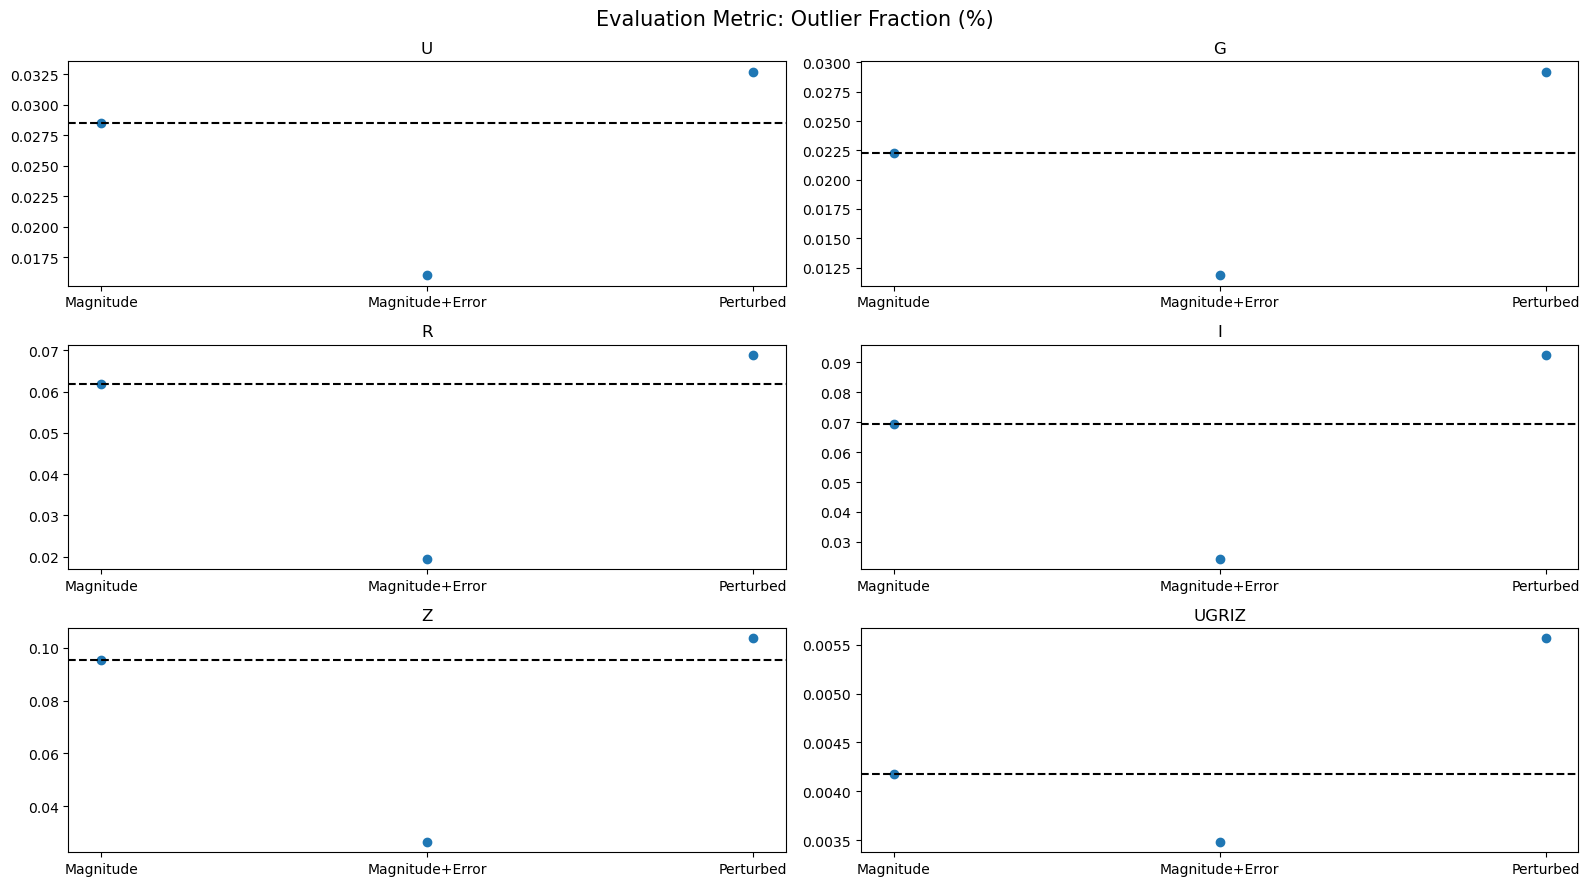

In [23]:
#Outlier Fraction
fig, axs = plt.subplots(3, 2, figsize=(16,9), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Evaluation Metric: Outlier Fraction (%)', fontsize=15)

axs[0,0].scatter(U_Sum['Condition'], U_Sum['Outlier'])
axs[0,0].axhline(y = Outlier_Umag, color = 'k', linestyle = '--')
axs[0,0].set_title('U')
axs[0,1].scatter(G_Sum['Condition'], G_Sum['Outlier'])
axs[0,1].axhline(y = Outlier_Gmag, color = 'k', linestyle = '--')
axs[0,1].set_title('G')
axs[1,0].scatter(R_Sum['Condition'], R_Sum['Outlier'])
axs[1,0].axhline(y = Outlier_Rmag, color = 'k', linestyle = '--')
axs[1,0].set_title('R')
axs[1,1].scatter(I_Sum['Condition'], I_Sum['Outlier'])
axs[1,1].axhline(y = Outlier_Imag, color = 'k', linestyle = '--')
axs[1,1].set_title('I')
axs[2,0].scatter(Z_Sum['Condition'], Z_Sum['Outlier'])
axs[2,0].axhline(y = Outlier_Zmag, color = 'k', linestyle = '--')
axs[2,0].set_title('Z')
axs[2,1].scatter(UGRIZ_Sum['Condition'], UGRIZ_Sum['Outlier'])
axs[2,1].axhline(y = Outlier_UGRIZmag, color = 'k', linestyle = '--')
axs[2,1].set_title('UGRIZ')

Text(0.5, 1.0, 'UGRIZ')

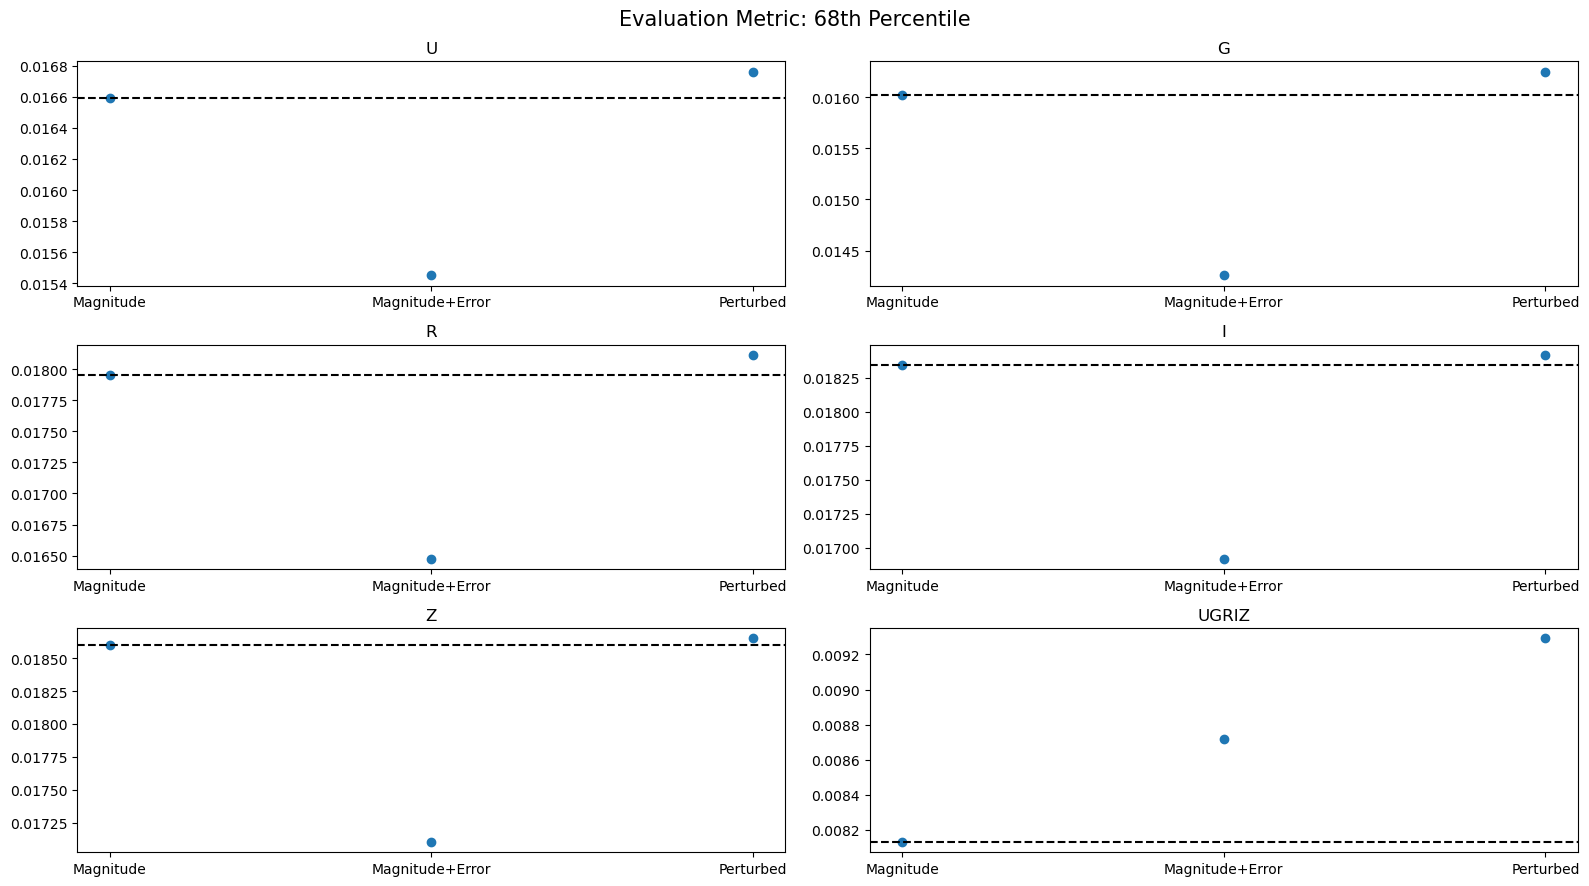

In [24]:
#68th Percentile
fig, axs = plt.subplots(3, 2, figsize=(16,9), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Evaluation Metric: 68th Percentile', fontsize=15)

axs[0,0].scatter(U_Sum['Condition'], U_Sum['68th'])
axs[0,0].axhline(y = Perc68_Umag, color = 'k', linestyle = '--')
axs[0,0].set_title('U')
axs[0,1].scatter(G_Sum['Condition'], G_Sum['68th'])
axs[0,1].axhline(y = Perc68_Gmag, color = 'k', linestyle = '--')
axs[0,1].set_title('G')
axs[1,0].scatter(R_Sum['Condition'], R_Sum['68th'])
axs[1,0].axhline(y = Perc68_Rmag, color = 'k', linestyle = '--')
axs[1,0].set_title('R')
axs[1,1].scatter(I_Sum['Condition'], I_Sum['68th'])
axs[1,1].axhline(y = Perc68_Imag, color = 'k', linestyle = '--')
axs[1,1].set_title('I')
axs[2,0].scatter(Z_Sum['Condition'], Z_Sum['68th'])
axs[2,0].axhline(y = Perc68_Zmag, color = 'k', linestyle = '--')
axs[2,0].set_title('Z')
axs[2,1].scatter(UGRIZ_Sum['Condition'], UGRIZ_Sum['68th'])
axs[2,1].axhline(y = Perc68_UGRIZmag, color = 'k', linestyle = '--')
axs[2,1].set_title('UGRIZ')

Text(0.5, 1.0, 'UGRIZ')

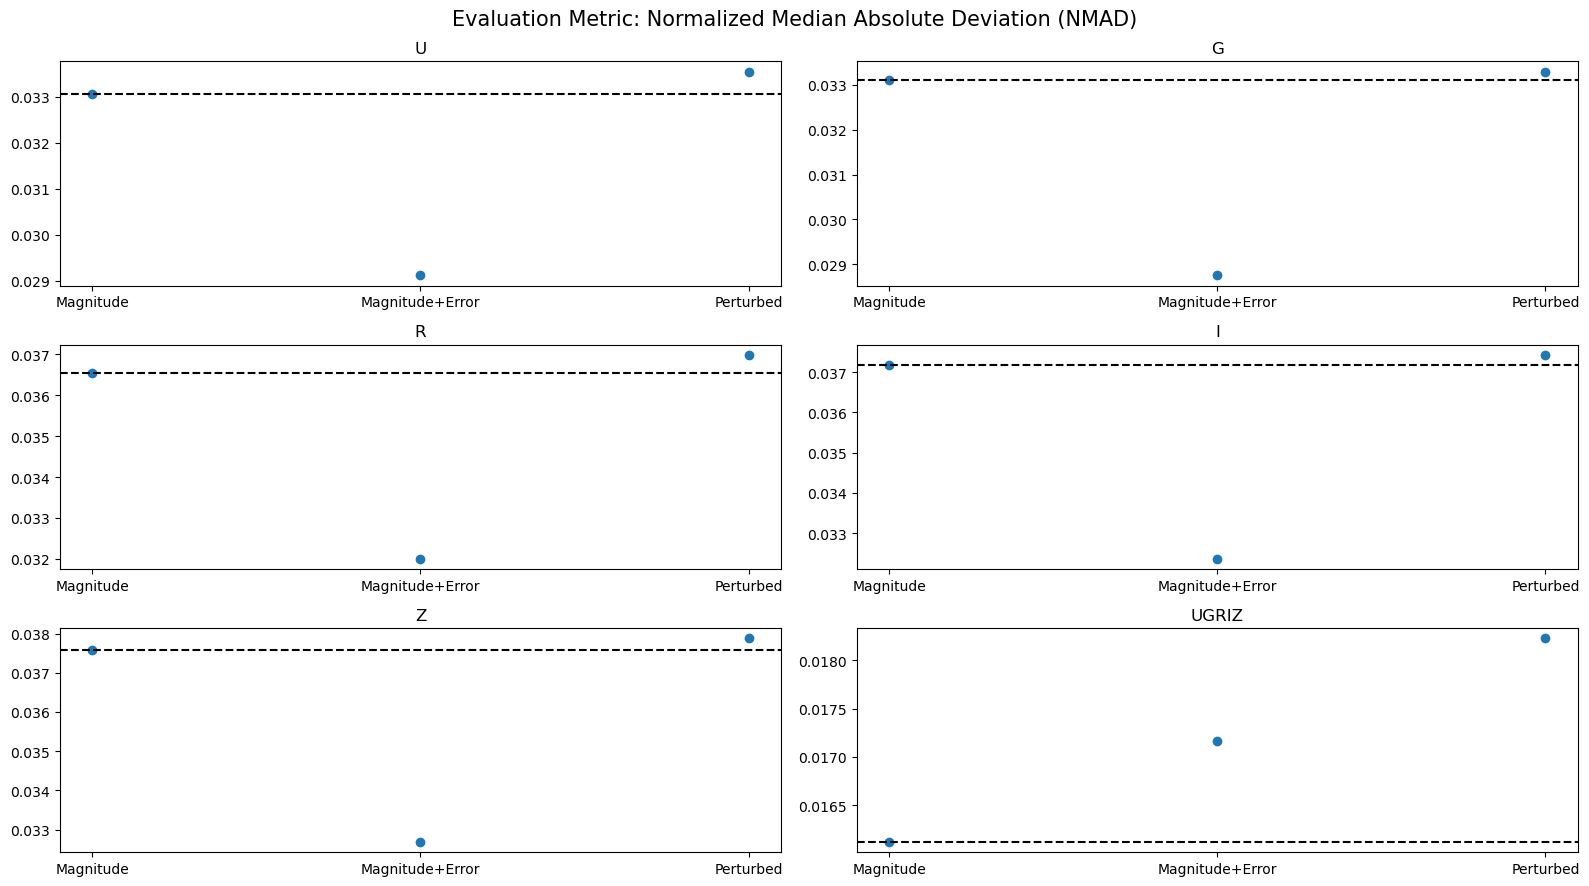

In [25]:
#NMAD
fig, axs = plt.subplots(3, 2, figsize=(16,9), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('Evaluation Metric: Normalized Median Absolute Deviation (NMAD)', fontsize=15)

axs[0,0].scatter(U_Sum['Condition'], U_Sum['NMAD'])
axs[0,0].axhline(y = NMAD_Umag, color = 'k', linestyle = '--')
axs[0,0].set_title('U')
axs[0,1].scatter(G_Sum['Condition'], G_Sum['NMAD'])
axs[0,1].axhline(y = NMAD_Gmag, color = 'k', linestyle = '--')
axs[0,1].set_title('G')
axs[1,0].scatter(R_Sum['Condition'], R_Sum['NMAD'])
axs[1,0].axhline(y = NMAD_Rmag, color = 'k', linestyle = '--')
axs[1,0].set_title('R')
axs[1,1].scatter(I_Sum['Condition'], I_Sum['NMAD'])
axs[1,1].axhline(y = NMAD_Imag, color = 'k', linestyle = '--')
axs[1,1].set_title('I')
axs[2,0].scatter(Z_Sum['Condition'], Z_Sum['NMAD'])
axs[2,0].axhline(y = NMAD_Zmag, color = 'k', linestyle = '--')
axs[2,0].set_title('Z')
axs[2,1].scatter(UGRIZ_Sum['Condition'], UGRIZ_Sum['NMAD'])
axs[2,1].axhline(y = NMAD_UGRIZmag, color = 'k', linestyle = '--')
axs[2,1].set_title('UGRIZ')

<h2>C. Combinations of bands and effects on photo-z estimation. Which band degrades the performance of photo-z?</h2>

In [26]:
## UGRIZ, U, G, R, I, Z
#UGRIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_UGRIZ, zPhoto_UGRIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ, Outlier_UGRIZ, Perc68_UGRIZ, NMAD_UGRIZ = Eval_metric(zSpec_UGRIZ, zPhoto_UGRIZ)

#U
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u']])
model = RandomForestRegressor()
zSpec_U, zPhoto_U = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_U, Outlier_U, Perc68_U, NMAD_U = Eval_metric(zSpec_U, zPhoto_U)

#G
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g']])
model = RandomForestRegressor()
zSpec_G, zPhoto_G = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_G, Outlier_G, Perc68_G, NMAD_G = Eval_metric(zSpec_G, zPhoto_G)

#R
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_r']])
model = RandomForestRegressor()
zSpec_R, zPhoto_R = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_R, Outlier_R, Perc68_R, NMAD_R = Eval_metric(zSpec_R, zPhoto_R)

#I
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i']])
model = RandomForestRegressor()
zSpec_I, zPhoto_I = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I, Outlier_I, Perc68_I, NMAD_I = Eval_metric(zSpec_I, zPhoto_I)

#Z
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_z']])
model = RandomForestRegressor()
zSpec_Z, zPhoto_Z = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_Z, Outlier_Z, Perc68_Z, NMAD_Z = Eval_metric(zSpec_Z, zPhoto_Z)

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(14,14), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('5 + 1 Bands', fontsize=25)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_U, zPhoto_U, zRange=0.3, title='U')
subplot_PE(0, 1, zSpec_G, zPhoto_G, zRange=0.3, title='G')
subplot_PE(0, 2, zSpec_R, zPhoto_R, zRange=0.3, title='R')
subplot_PE(1, 0, zSpec_I, zPhoto_I, zRange=0.3, title='I')
subplot_PE(1, 1, zSpec_Z, zPhoto_Z, zRange=0.3, title='Z')
subplot_PE(1, 2, zSpec_UGRIZ, zPhoto_UGRIZ, zRange=0.3, title='UGRIZ')

In [28]:
## UGRI, UGRZ, UGIZ, URIZ, GRIZ
#UGRI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i']])
model = RandomForestRegressor()
zSpec_UGRI, zPhoto_UGRI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRI, Outlier_UGRI, Perc68_UGRI, NMAD_UGRI = Eval_metric(zSpec_UGRI, zPhoto_UGRI)

#UGRZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_z']])
model = RandomForestRegressor()
zSpec_UGRZ, zPhoto_UGRZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRZ, Outlier_UGRZ, Perc68_UGRZ, NMAD_UGRZ = Eval_metric(zSpec_UGRZ, zPhoto_UGRZ)

#UGIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_UGIZ, zPhoto_UGIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGIZ, Outlier_UGIZ, Perc68_UGIZ, NMAD_UGIZ = Eval_metric(zSpec_UGIZ, zPhoto_UGIZ)

#URIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_r', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_URIZ, zPhoto_URIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_URIZ, Outlier_URIZ, Perc68_URIZ, NMAD_URIZ = Eval_metric(zSpec_URIZ, zPhoto_URIZ)

#GRIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_r', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_GRIZ, zPhoto_GRIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GRIZ, Outlier_GRIZ, Perc68_GRIZ, NMAD_GRIZ = Eval_metric(zSpec_GRIZ, zPhoto_GRIZ)

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(14,14), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('4 Bands', fontsize=25)
axs[1,2].set_visible(False)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_UGRI, zPhoto_UGRI, zRange=0.3, title='UGRI')
subplot_PE(0, 1, zSpec_UGRZ, zPhoto_UGRZ, zRange=0.3, title='UGRZ')
subplot_PE(0, 2, zSpec_UGIZ, zPhoto_UGIZ, zRange=0.3, title='UGIZ')
subplot_PE(1, 0, zSpec_URIZ, zPhoto_URIZ, zRange=0.3, title='URIZ')
subplot_PE(1, 1, zSpec_GRIZ, zPhoto_GRIZ, zRange=0.3, title='GRIZ')

In [30]:
## UGR, UGI, UGZ, URI, URZ, UIZ, GRI, GRZ, GIZ, RIZ
#UGR
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r']])
model = RandomForestRegressor()
zSpec_UGR, zPhoto_UGR = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGR, Outlier_UGR, Perc68_UGR, NMAD_UGR = Eval_metric(zSpec_UGR, zPhoto_UGR)

#UGI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_i']])
model = RandomForestRegressor()
zSpec_UGI, zPhoto_UGI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGI, Outlier_UGI, Perc68_UGI, NMAD_UGI = Eval_metric(zSpec_UGI, zPhoto_UGI)

#UGZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_z']])
model = RandomForestRegressor()
zSpec_UGZ, zPhoto_UGZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGZ, Outlier_UGZ, Perc68_UGZ, NMAD_UGZ = Eval_metric(zSpec_UGZ, zPhoto_UGZ)

#URI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_r', 'dered_i']])
model = RandomForestRegressor()
zSpec_URI, zPhoto_URI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_URI, Outlier_URI, Perc68_URI, NMAD_URI = Eval_metric(zSpec_URI, zPhoto_URI)

#URZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_r', 'dered_z']])
model = RandomForestRegressor()
zSpec_URZ, zPhoto_URZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_URZ, Outlier_URZ, Perc68_URZ, NMAD_URZ = Eval_metric(zSpec_URZ, zPhoto_URZ)

#UIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_UIZ, zPhoto_UIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UIZ, Outlier_UIZ, Perc68_UIZ, NMAD_UIZ = Eval_metric(zSpec_UIZ, zPhoto_UIZ)

#GRI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_r', 'dered_i']])
model = RandomForestRegressor()
zSpec_GRI, zPhoto_GRI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GRI, Outlier_GRI, Perc68_GRI, NMAD_GRI = Eval_metric(zSpec_GRI, zPhoto_GRI)

#GRZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_r', 'dered_z']])
model = RandomForestRegressor()
zSpec_GRZ, zPhoto_GRZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GRZ, Outlier_GRZ, Perc68_GRZ, NMAD_GRZ = Eval_metric(zSpec_GRZ, zPhoto_GRZ)

#GIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_GIZ, zPhoto_GIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GIZ, Outlier_GIZ, Perc68_GIZ, NMAD_GIZ = Eval_metric(zSpec_GIZ, zPhoto_GIZ)

#RIZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_r', 'dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_RIZ, zPhoto_RIZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_RIZ, Outlier_RIZ, Perc68_RIZ, NMAD_RIZ = Eval_metric(zSpec_RIZ, zPhoto_RIZ)

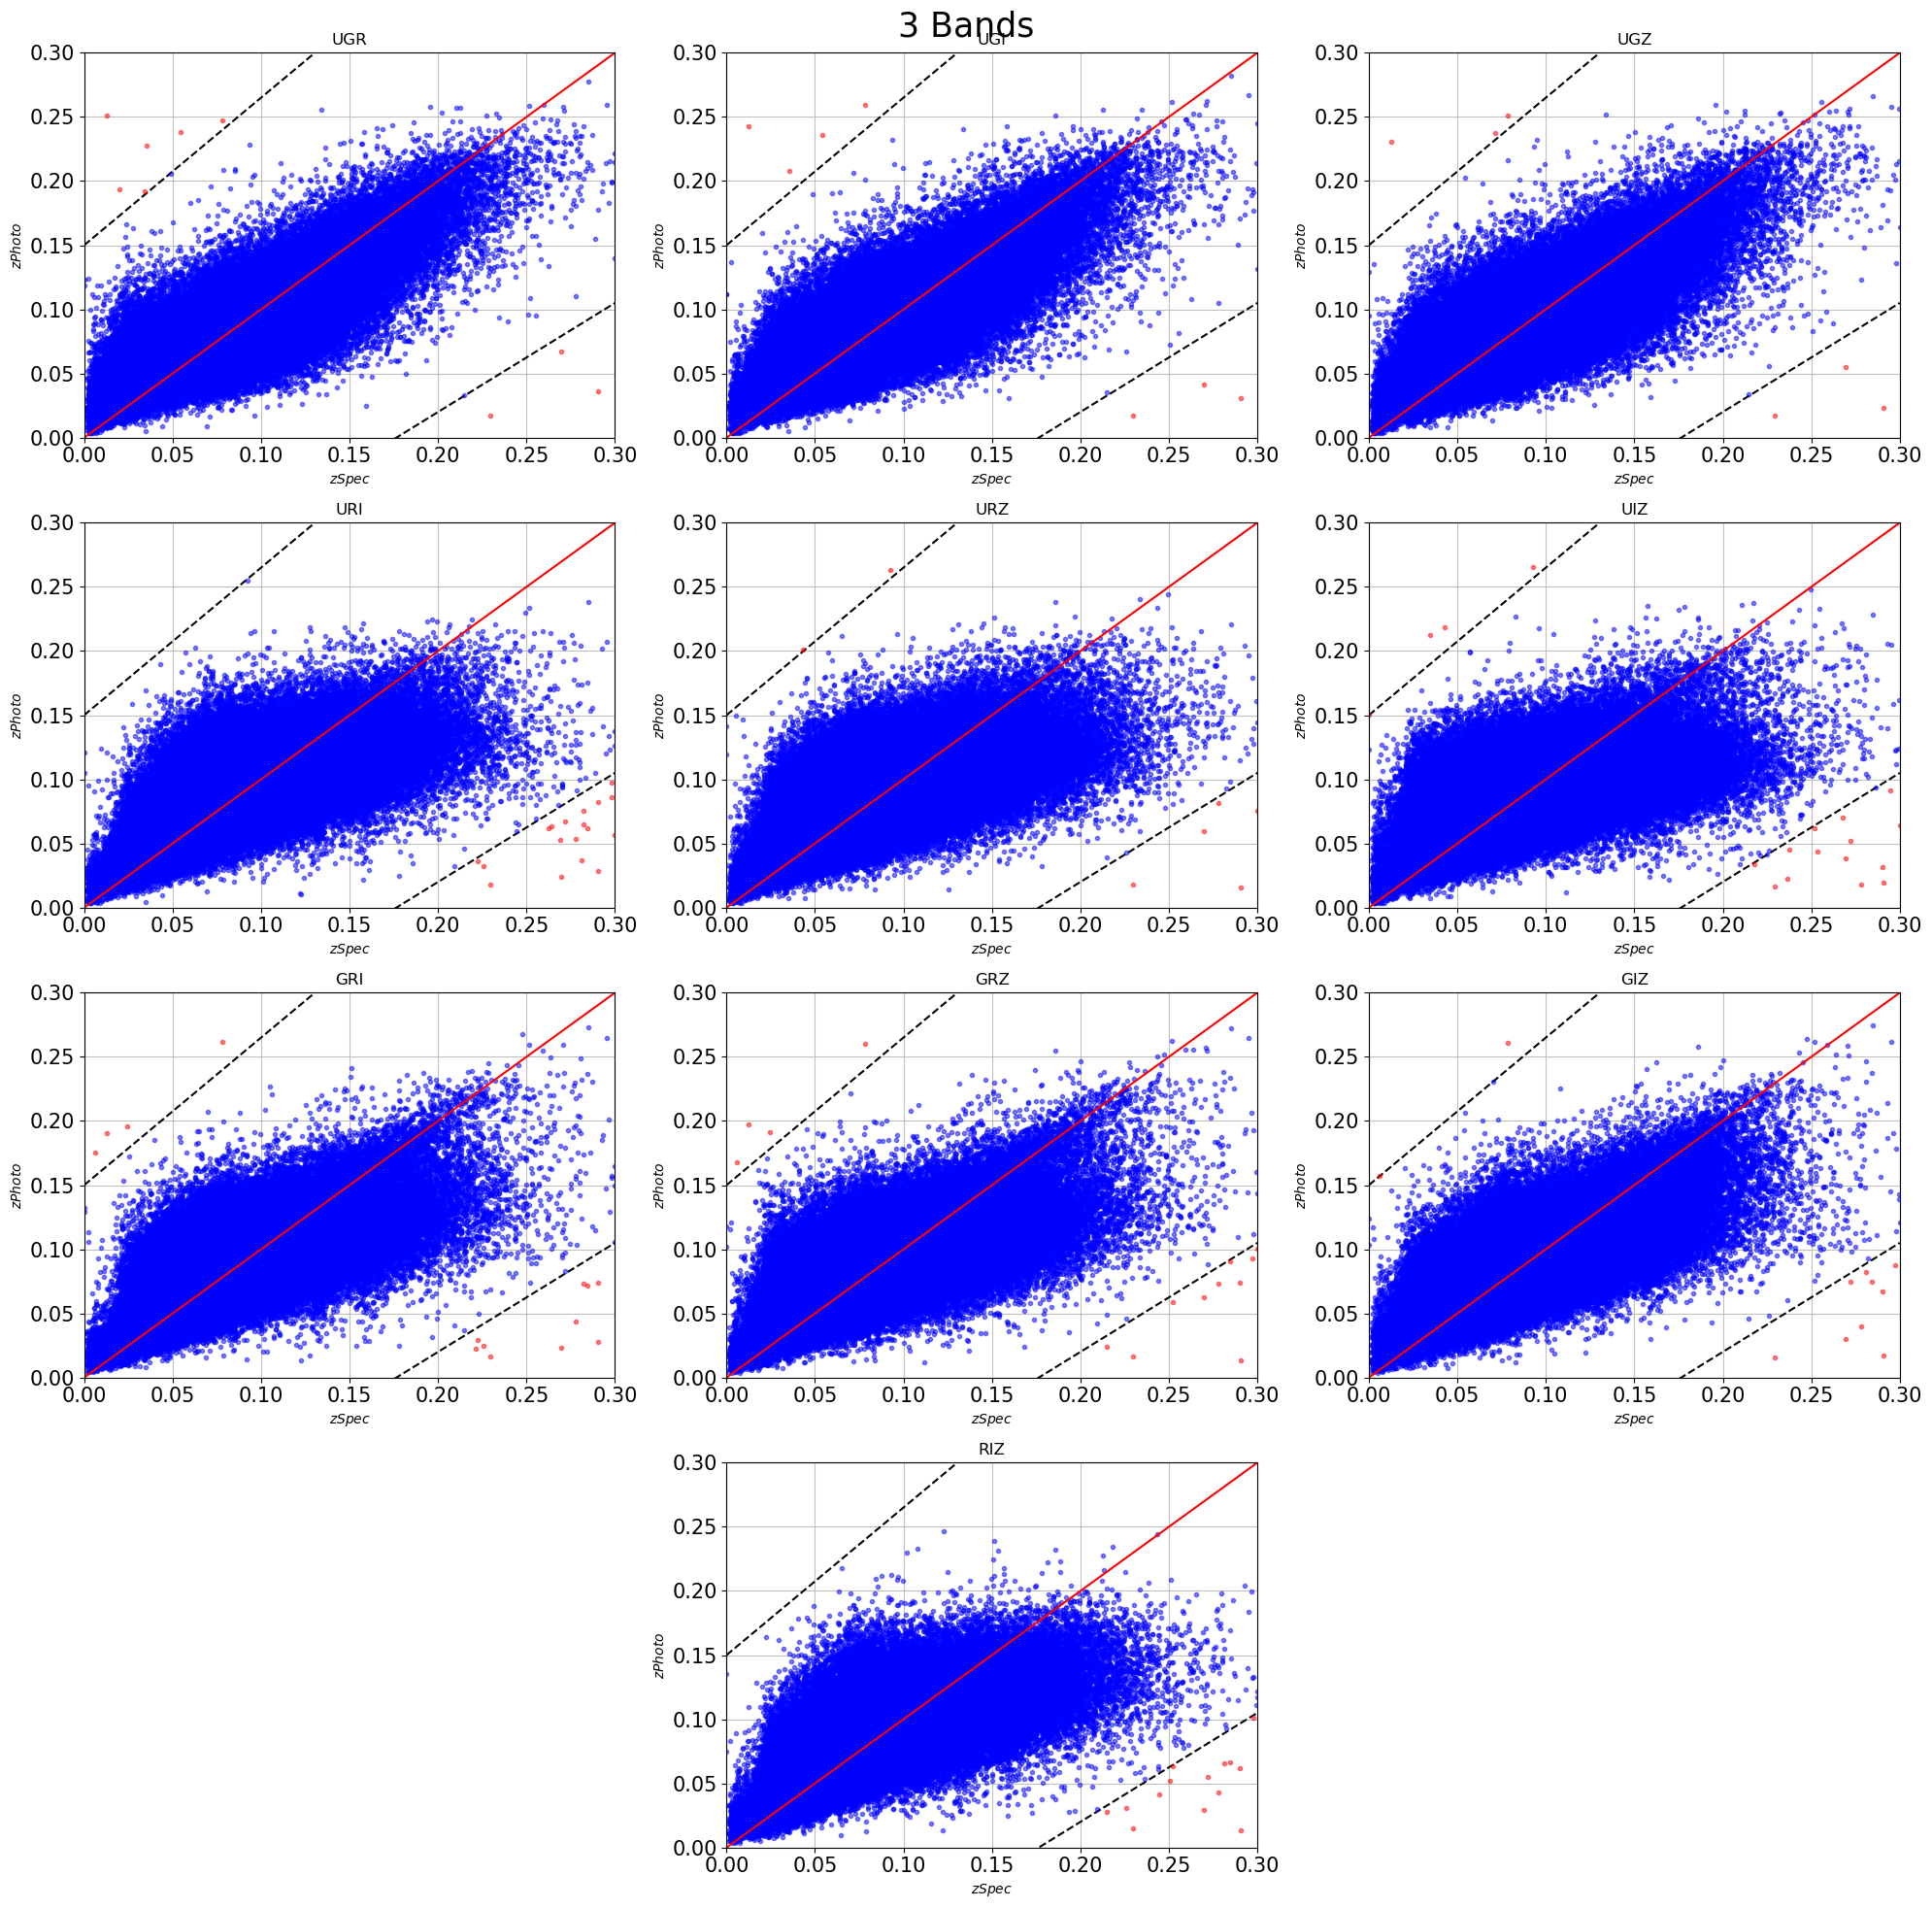

In [31]:
fig, axs = plt.subplots(4, 3, figsize=(20,20), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('3 Bands', fontsize=25)
axs[3,0].set_visible(False)
axs[3,2].set_visible(False)

subplot_PE(0, 0, zSpec_UGR, zPhoto_UGR, zRange=0.3, title='UGR')
subplot_PE(0, 1, zSpec_UGI, zPhoto_UGI, zRange=0.3, title='UGI')
subplot_PE(0, 2, zSpec_UGZ, zPhoto_UGZ, zRange=0.3, title='UGZ')
subplot_PE(1, 0, zSpec_URI, zPhoto_URI, zRange=0.3, title='URI')
subplot_PE(1, 1, zSpec_URZ, zPhoto_URZ, zRange=0.3, title='URZ')
subplot_PE(1, 2, zSpec_UIZ, zPhoto_UIZ, zRange=0.3, title='UIZ')
subplot_PE(2, 0, zSpec_GRI, zPhoto_GRI, zRange=0.3, title='GRI')
subplot_PE(2, 1, zSpec_GRZ, zPhoto_GRZ, zRange=0.3, title='GRZ')
subplot_PE(2, 2, zSpec_GIZ, zPhoto_GIZ, zRange=0.3, title='GIZ')
subplot_PE(3, 1, zSpec_RIZ, zPhoto_RIZ, zRange=0.3, title='RIZ')

In [32]:
## UG, UR, UI, UZ, GR, GI, GZ, RI, RZ, IZ
#UG
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g']])
model = RandomForestRegressor()
zSpec_UG, zPhoto_UG = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UG, Outlier_UG, Perc68_UG, NMAD_UG = Eval_metric(zSpec_UG, zPhoto_UG)

#UR
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_r']])
model = RandomForestRegressor()
zSpec_UR, zPhoto_UR = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UR, Outlier_UR, Perc68_UR, NMAD_UR = Eval_metric(zSpec_UR, zPhoto_UR)

#UI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_i']])
model = RandomForestRegressor()
zSpec_UI, zPhoto_UI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UI, Outlier_UI, Perc68_UI, NMAD_UI = Eval_metric(zSpec_UI, zPhoto_UI)

#UZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_z']])
model = RandomForestRegressor()
zSpec_UZ, zPhoto_UZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UZ, Outlier_UZ, Perc68_UZ, NMAD_UZ = Eval_metric(zSpec_UZ, zPhoto_UZ)

#GR
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_r']])
model = RandomForestRegressor()
zSpec_GR, zPhoto_GR = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GR, Outlier_GR, Perc68_GR, NMAD_GR = Eval_metric(zSpec_GR, zPhoto_GR)

#GI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_i']])
model = RandomForestRegressor()
zSpec_GI, zPhoto_GI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GI, Outlier_GI, Perc68_GI, NMAD_GI = Eval_metric(zSpec_GI, zPhoto_GI)

#GZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_g', 'dered_z']])
model = RandomForestRegressor()
zSpec_GZ, zPhoto_GZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_GZ, Outlier_GZ, Perc68_GZ, NMAD_GZ = Eval_metric(zSpec_GZ, zPhoto_GZ)

#RI
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_r', 'dered_i']])
model = RandomForestRegressor()
zSpec_RI, zPhoto_RI = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_RI, Outlier_RI, Perc68_RI, NMAD_RI = Eval_metric(zSpec_RI, zPhoto_RI)

#RZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_r', 'dered_z']])
model = RandomForestRegressor()
zSpec_RZ, zPhoto_RZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_RZ, Outlier_RZ, Perc68_RZ, NMAD_RZ = Eval_metric(zSpec_RZ, zPhoto_RZ)

#IZ
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'dered_z']])
model = RandomForestRegressor()
zSpec_IZ, zPhoto_IZ = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_IZ, Outlier_IZ, Perc68_IZ, NMAD_IZ = Eval_metric(zSpec_IZ, zPhoto_IZ)

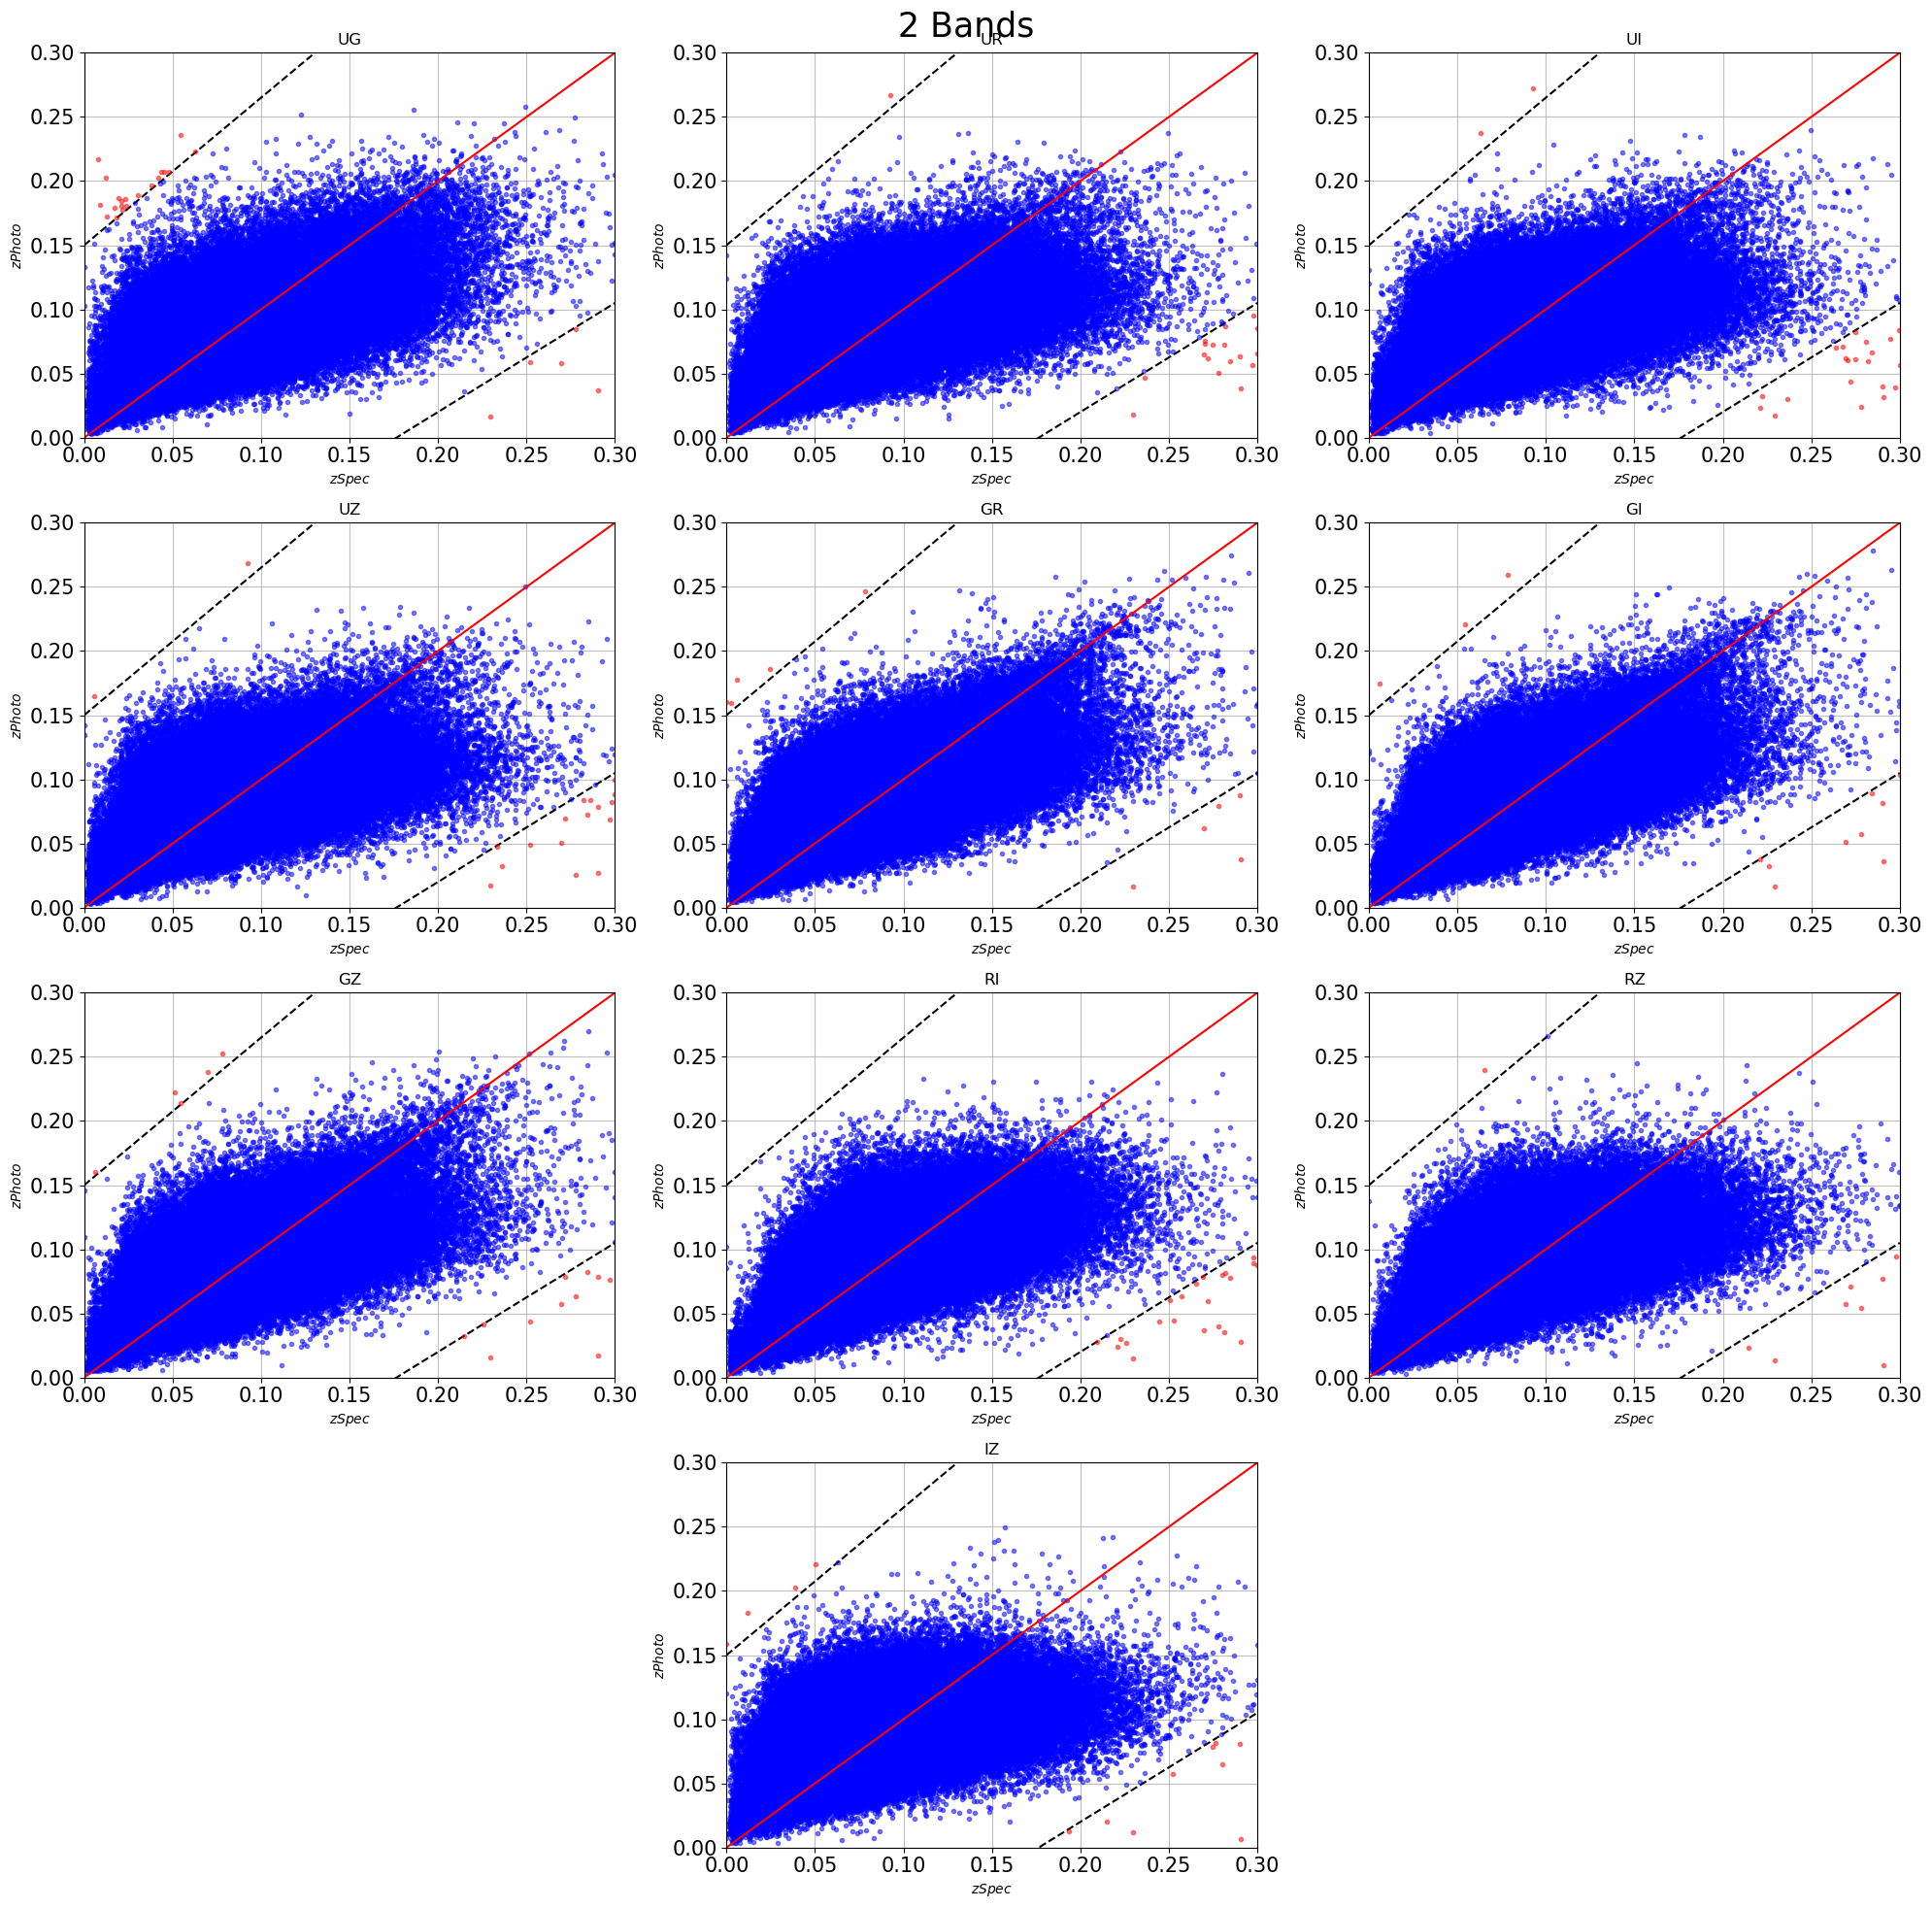

In [33]:
fig, axs = plt.subplots(4, 3, figsize=(20,20), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('2 Bands', fontsize=25)
axs[3,0].set_visible(False)
axs[3,2].set_visible(False)

subplot_PE(0, 0, zSpec_UG, zPhoto_UG, zRange=0.3, title='UG')
subplot_PE(0, 1, zSpec_UR, zPhoto_UR, zRange=0.3, title='UR')
subplot_PE(0, 2, zSpec_UI, zPhoto_UI, zRange=0.3, title='UI')
subplot_PE(1, 0, zSpec_UZ, zPhoto_UZ, zRange=0.3, title='UZ')
subplot_PE(1, 1, zSpec_GR, zPhoto_GR, zRange=0.3, title='GR')
subplot_PE(1, 2, zSpec_GI, zPhoto_GI, zRange=0.3, title='GI')
subplot_PE(2, 0, zSpec_GZ, zPhoto_GZ, zRange=0.3, title='GZ')
subplot_PE(2, 1, zSpec_RI, zPhoto_RI, zRange=0.3, title='RI')
subplot_PE(2, 2, zSpec_RZ, zPhoto_RZ, zRange=0.3, title='RZ')
subplot_PE(3, 1, zSpec_IZ, zPhoto_IZ, zRange=0.3, title='IZ')

In [34]:
data = [['U', RMSE_U, Outlier_U, Perc68_U, NMAD_U], ['G', RMSE_G, Outlier_G, Perc68_G, NMAD_G], 
        ['R', RMSE_R, Outlier_R, Perc68_R, NMAD_R], ['I', RMSE_I, Outlier_I, Perc68_I, NMAD_I], 
        ['Z', RMSE_Z, Outlier_Z, Perc68_Z, NMAD_Z], ['UG', RMSE_UG, Outlier_UG, Perc68_UG, NMAD_UG],
        ['UR', RMSE_UR, Outlier_UR, Perc68_UR, NMAD_UR], ['UI', RMSE_UI, Outlier_UI, Perc68_UI, NMAD_UI], 
        ['UZ', RMSE_UZ, Outlier_UZ, Perc68_UZ, NMAD_UZ], ['GR', RMSE_GR, Outlier_GR, Perc68_GR, NMAD_GR], 
        ['GI', RMSE_GI, Outlier_GI, Perc68_GI, NMAD_GI], ['GZ', RMSE_GZ, Outlier_GZ, Perc68_GZ, NMAD_GZ],
        ['RI', RMSE_RI, Outlier_RI, Perc68_RI, NMAD_RI], ['RZ', RMSE_RZ, Outlier_RZ, Perc68_RZ, NMAD_RZ], 
        ['IZ', RMSE_IZ, Outlier_IZ, Perc68_IZ, NMAD_IZ], ['UGR', RMSE_UGR, Outlier_UGR, Perc68_UGR, NMAD_UGR], 
        ['UGI', RMSE_UGI, Outlier_UGI, Perc68_UGI, NMAD_UGI], ['UGZ', RMSE_UGZ, Outlier_UGZ, Perc68_UGZ, NMAD_UGZ],
        ['URI', RMSE_URI, Outlier_URI, Perc68_URI, NMAD_URI], ['URZ', RMSE_URZ, Outlier_URZ, Perc68_URZ, NMAD_URZ], 
        ['UIZ', RMSE_UIZ, Outlier_UIZ, Perc68_UIZ, NMAD_UIZ],['GRI', RMSE_GRI, Outlier_GRI, Perc68_GRI, NMAD_GRI], 
        ['GRZ', RMSE_GRZ, Outlier_GRZ, Perc68_GRZ, NMAD_GRZ], ['GIZ', RMSE_GIZ, Outlier_GIZ, Perc68_GIZ, NMAD_GIZ],
        ['RIZ', RMSE_RIZ, Outlier_RIZ, Perc68_RIZ, NMAD_RIZ], ['UGRI', RMSE_UGRI, Outlier_UGRI, Perc68_UGRI, NMAD_UGRI], 
        ['UGRZ', RMSE_UGRZ, Outlier_UGRZ, Perc68_UGRZ, NMAD_UGRZ],['UGIZ', RMSE_UGIZ, Outlier_UGIZ, Perc68_UGIZ, NMAD_UGIZ], 
        ['URIZ', RMSE_URIZ, Outlier_URIZ, Perc68_URIZ, NMAD_URIZ], ['GRIZ', RMSE_GRIZ, Outlier_GRIZ, Perc68_GRIZ, NMAD_GRIZ],
        ['UGRIZ', RMSE_UGRIZ, Outlier_UGRIZ, Perc68_UGRIZ, NMAD_UGRIZ]]
Sum = pd.DataFrame(data, columns=['Condition', 'RMSE', 'Outlier', '68th', 'NMAD'])

Text(0.5, 1.0, 'Metric: NMAD')

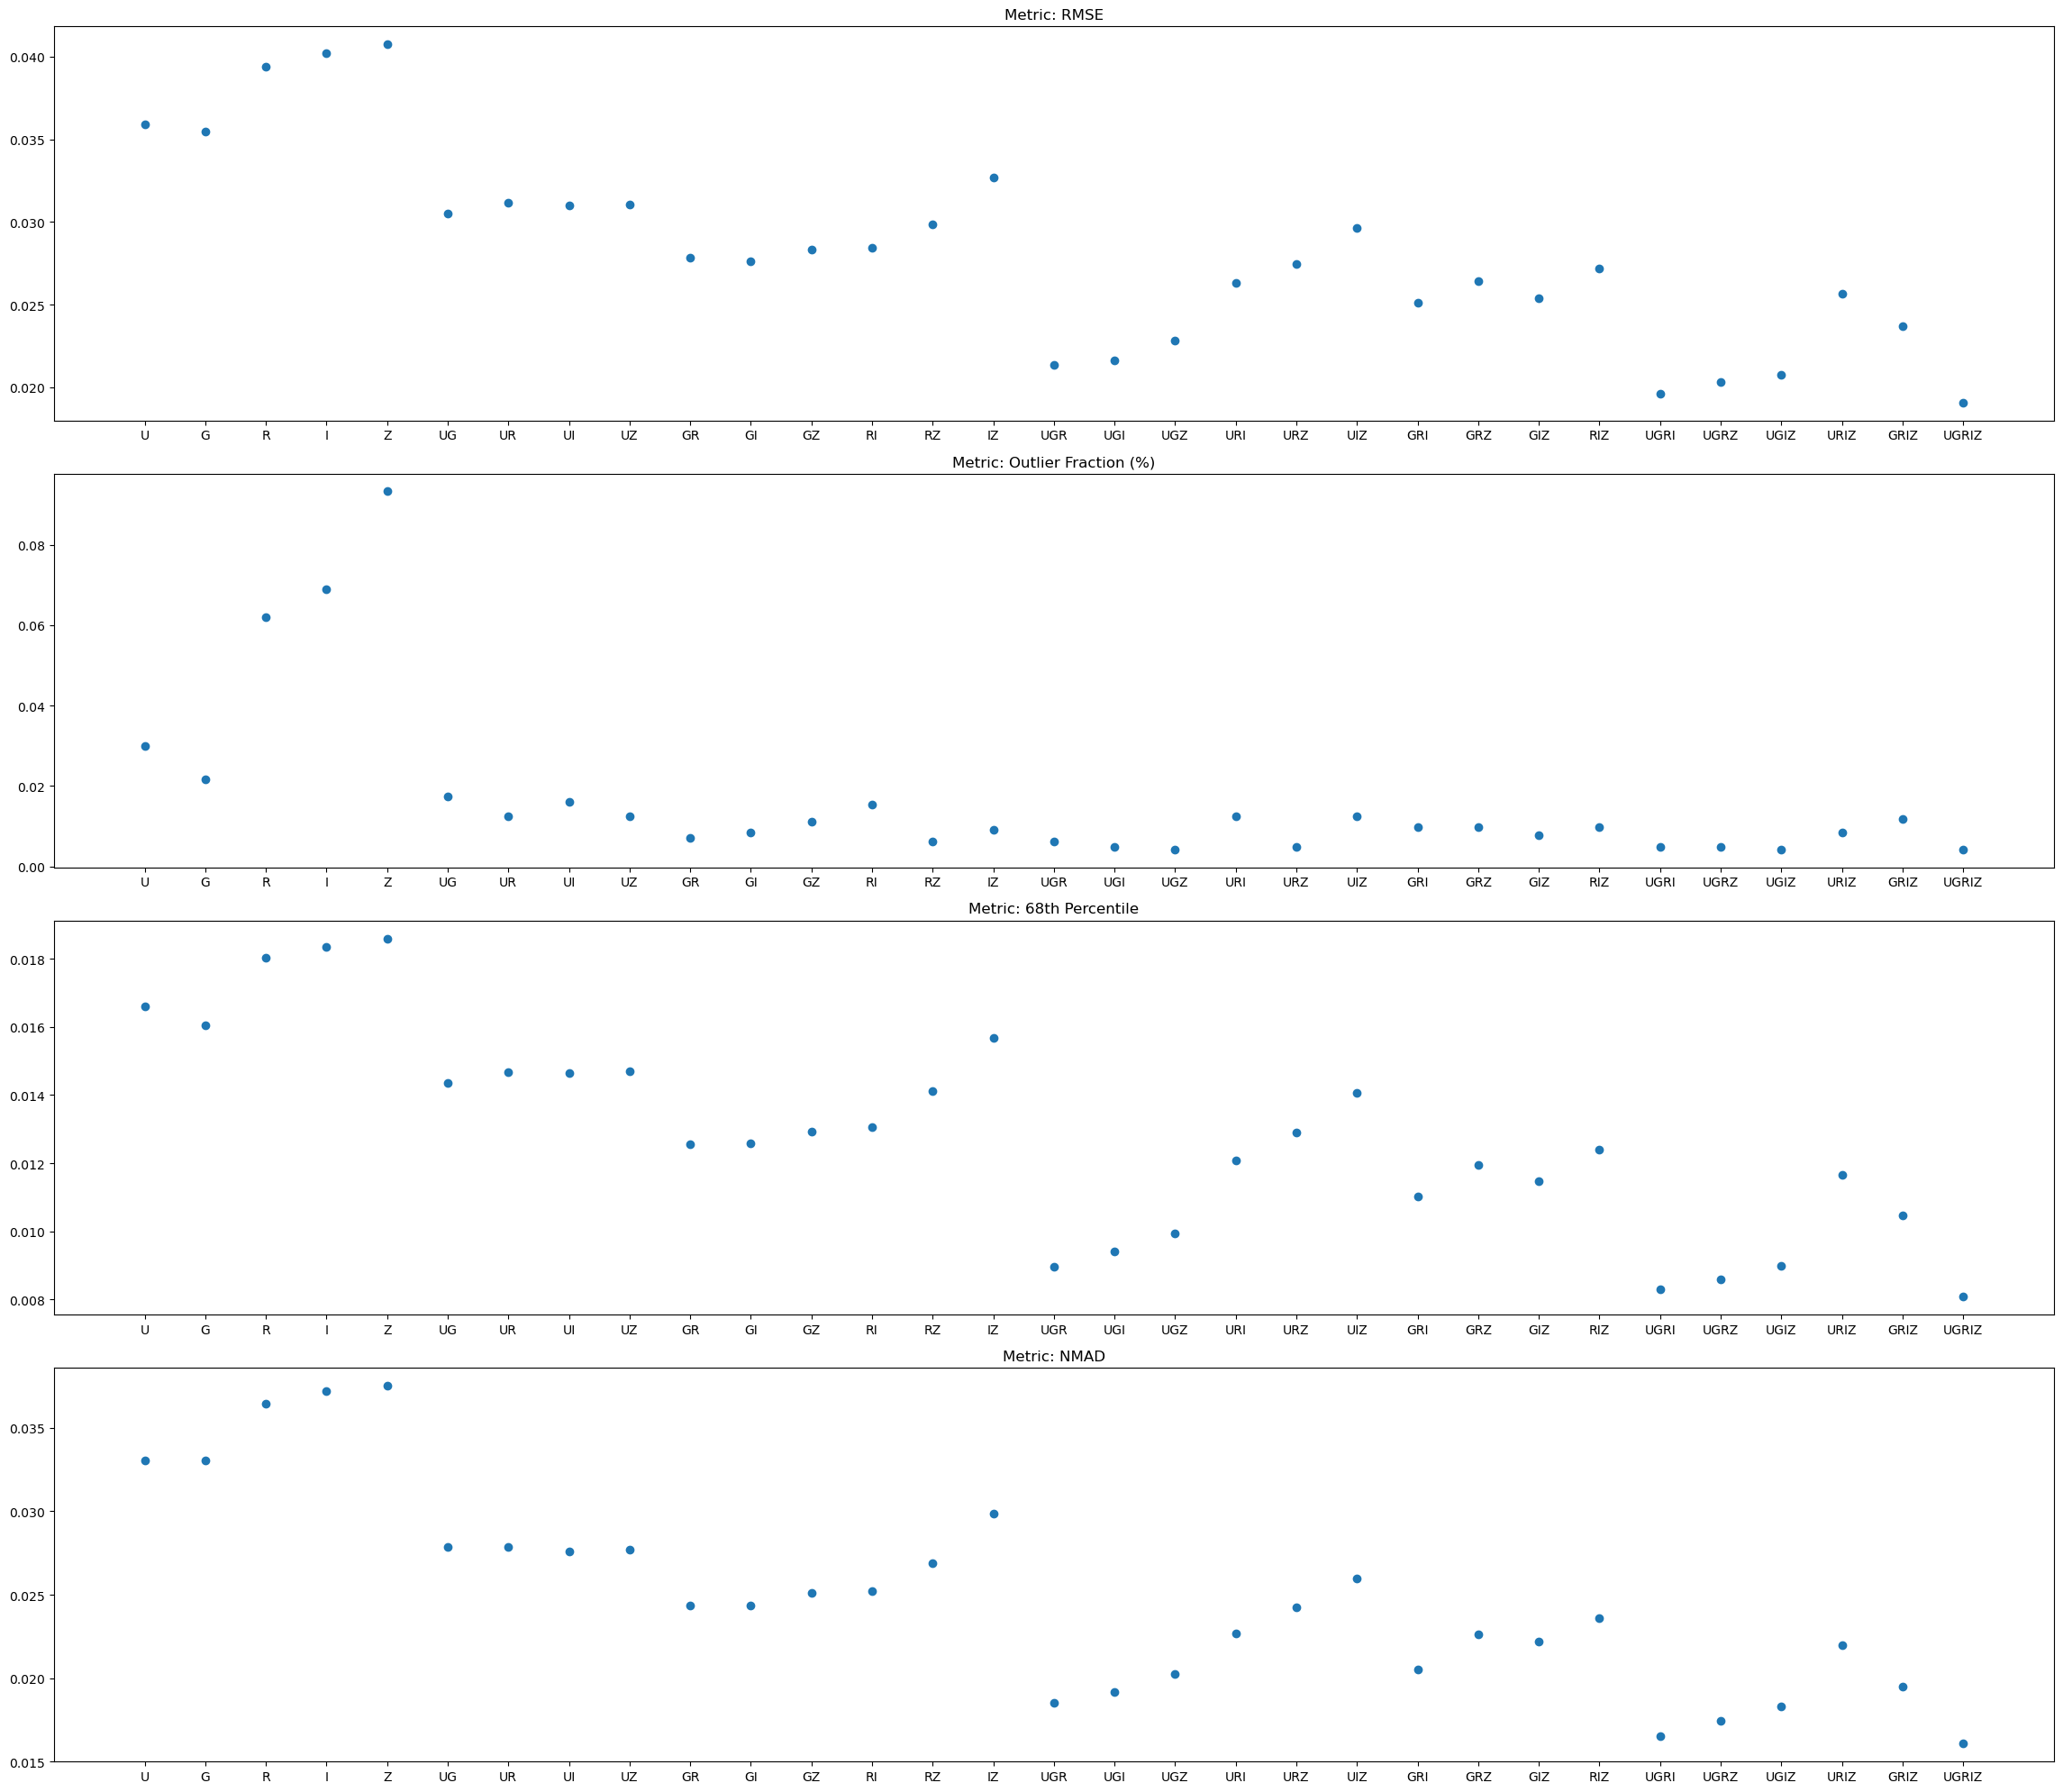

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(23,20), tight_layout=True, sharex=False, sharey=False)
#fig.suptitle('Evaluation Metric: U-Band', fontsize=15)

axs[0].scatter(Sum['Condition'], Sum['RMSE'])
axs[0].set_title('Metric: RMSE')
axs[1].scatter(Sum['Condition'], Sum['Outlier'])
axs[1].set_title('Metric: Outlier Fraction (%)')
axs[2].scatter(Sum['Condition'], Sum['68th'])
axs[2].set_title('Metric: 68th Percentile')
axs[3].scatter(Sum['Condition'], Sum['NMAD'])
axs[3].set_title('Metric: NMAD')

<h2>D. Effects of photo-z estimation when additional information (e.g., Morpohlogy) is added</h2>

<h3>UGRIZ+</h3>

In [36]:
#deVRad_i (R)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'deVRad_i']])
model = RandomForestRegressor()

zSpec_UGRIZ_R, zPhoto_UGRIZ_R = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ_R, Outlier_UGRIZ_R, Perc68_UGRIZ_R, NMAD_UGRIZ_R = Eval_metric(zSpec_UGRIZ_R, zPhoto_UGRIZ_R)

#deVAB_i (AB)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'deVAB_i']])
model = RandomForestRegressor()

zSpec_UGRIZ_AB, zPhoto_UGRIZ_AB = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ_AB, Outlier_UGRIZ_AB, Perc68_UGRIZ_AB, NMAD_UGRIZ_AB = Eval_metric(zSpec_UGRIZ_AB, zPhoto_UGRIZ_AB)

#deVMu_i (Mu)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'deVMu_i']])
model = RandomForestRegressor()

zSpec_UGRIZ_Mu, zPhoto_UGRIZ_Mu = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ_Mu, Outlier_UGRIZ_Mu, Perc68_UGRIZ_Mu, NMAD_UGRIZ_Mu = Eval_metric(zSpec_UGRIZ_Mu, zPhoto_UGRIZ_Mu)

#deVRad_i, deVAB_i (RA)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'deVRad_i', 'deVAB_i']])
model = RandomForestRegressor()

zSpec_UGRIZ_RA, zPhoto_UGRIZ_RA = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ_RA, Outlier_UGRIZ_RA, Perc68_UGRIZ_RA, NMAD_UGRIZ_RA = Eval_metric(zSpec_UGRIZ_RA, zPhoto_UGRIZ_RA)

#deVRad_i, deVMu_i (RM)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'deVRad_i', 'deVMu_i']])
model = RandomForestRegressor()

zSpec_UGRIZ_RM, zPhoto_UGRIZ_RM = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ_RM, Outlier_UGRIZ_RM, Perc68_UGRIZ_RM, NMAD_UGRIZ_RM = Eval_metric(zSpec_UGRIZ_RM, zPhoto_UGRIZ_RM)

#deVRad_i, deVAB_i, deVMu_i (RAM)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'deVRad_i', 'deVAB_i', 'deVMu_i']])
model = RandomForestRegressor()

zSpec_UGRIZ_RAM, zPhoto_UGRIZ_RAM = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_UGRIZ_RAM, Outlier_UGRIZ_RAM, Perc68_UGRIZ_RAM, NMAD_UGRIZ_RAM = Eval_metric(zSpec_UGRIZ_RAM, zPhoto_UGRIZ_RAM)

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(20,20), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('UGRIZ + Morpho', fontsize=20)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_UGRIZ_R, zPhoto_UGRIZ_R, zRange=0.3, title='Rad')
subplot_PE(0, 1, zSpec_UGRIZ_AB, zPhoto_UGRIZ_AB, zRange=0.3, title='AB')
subplot_PE(0, 2, zSpec_UGRIZ_Mu, zPhoto_UGRIZ_Mu, zRange=0.3, title='Mu')
subplot_PE(1, 0, zSpec_UGRIZ_RA, zPhoto_UGRIZ_RA, zRange=0.3, title='Rad, AB')
subplot_PE(1, 1, zSpec_UGRIZ_RM, zPhoto_UGRIZ_RM, zRange=0.3, title='Rad, Mu')
subplot_PE(1, 2, zSpec_UGRIZ_RAM, zPhoto_UGRIZ_RAM, zRange=0.3, title='Rad, AB, Mu')

In [38]:
# initialize list of lists
data = [['-', RMSE_UGRIZ, Outlier_UGRIZ, Perc68_UGRIZ, NMAD_UGRIZ],
        ['Rad', RMSE_UGRIZ_R, Outlier_UGRIZ_R, Perc68_UGRIZ_R, NMAD_UGRIZ_R], 
        ['AB', RMSE_UGRIZ_AB, Outlier_UGRIZ_AB, Perc68_UGRIZ_AB, NMAD_UGRIZ_AB], 
        ['Mu', RMSE_UGRIZ_Mu, Outlier_UGRIZ_Mu, Perc68_UGRIZ_Mu, NMAD_UGRIZ_Mu], 
        ['Rad,AB', RMSE_UGRIZ_RA, Outlier_UGRIZ_RA, Perc68_UGRIZ_RA, NMAD_UGRIZ_RA], 
        ['Rad,Mu', RMSE_UGRIZ_RM, Outlier_UGRIZ_RM, Perc68_UGRIZ_RM, NMAD_UGRIZ_RM], 
        ['Rad,AB,Mu', RMSE_UGRIZ_RAM, Outlier_UGRIZ_RAM, Perc68_UGRIZ_RAM, NMAD_UGRIZ_RAM]]

# Create the pandas DataFrame
Summary = pd.DataFrame(data, columns=['UGRIZ+', 'RMSE', 'Outlier', '68th', 'NMAD'])
print(Summary)

      UGRIZ+      RMSE   Outlier      68th      NMAD
0          -  0.019087  0.004175  0.008087  0.016071
1        Rad  0.018797  0.004175  0.008014  0.015867
2         AB  0.018767  0.004175  0.008042  0.015995
3         Mu  0.018526  0.004175  0.007859  0.015616
4     Rad,AB  0.018226  0.003479  0.007818  0.015598
5     Rad,Mu  0.018146  0.003479  0.007797  0.015335
6  Rad,AB,Mu  0.018263  0.003479  0.007894  0.015596


Text(0, 0.5, 'NMAD')

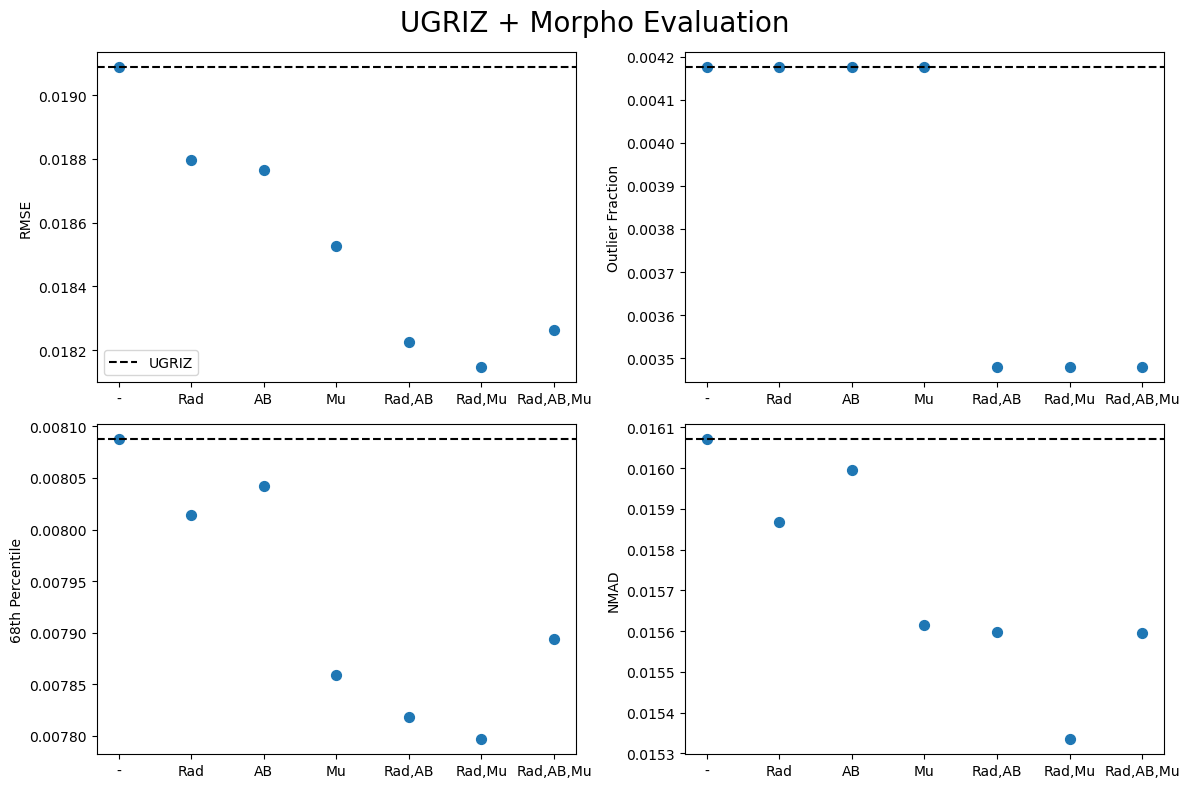

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(12,8), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('UGRIZ + Morpho Evaluation', fontsize=20)
axs[0,0].axhline(y = RMSE_UGRIZ, color = 'k', linestyle = '--', label='UGRIZ')
axs[0,0].scatter(Summary['UGRIZ+'], Summary['RMSE'], s=50)
axs[0,0].legend(loc='lower left')
axs[0,0].set_ylabel('RMSE')

axs[0,1].axhline(y = Outlier_UGRIZ, color = 'k', linestyle = '--')
axs[0,1].scatter(Summary['UGRIZ+'], Summary['Outlier'], s=50)
axs[0,1].set_ylabel('Outlier Fraction')

axs[1,0].axhline(y = Perc68_UGRIZ, color = 'k', linestyle = '--')
axs[1,0].scatter(Summary['UGRIZ+'], Summary['68th'], s=50)
axs[1,0].set_ylabel('68th Percentile')

axs[1,1].axhline(y = NMAD_UGRIZ, color = 'k', linestyle = '--')
axs[1,1].scatter(Summary['UGRIZ+'], Summary['NMAD'], s=50)
axs[1,1].set_ylabel('NMAD')

<h3>I +</h3>

In [40]:
#deVRad_i (R)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'dered_z', 'deVRad_i']])
model = RandomForestRegressor()

zSpec_I_R, zPhoto_I_R = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I_R, Outlier_I_R, Perc68_I_R, NMAD_I_R = Eval_metric(zSpec_I_R, zPhoto_I_R)

#deVAB_i (AB)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'dered_z', 'deVAB_i']])
model = RandomForestRegressor()

zSpec_I_AB, zPhoto_I_AB = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I_AB, Outlier_I_AB, Perc68_I_AB, NMAD_I_AB = Eval_metric(zSpec_I_AB, zPhoto_I_AB)

#deVMu_i (Mu)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'dered_z', 'deVMu_i']])
model = RandomForestRegressor()

zSpec_I_Mu, zPhoto_I_Mu = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I_Mu, Outlier_I_Mu, Perc68_I_Mu, NMAD_I_Mu = Eval_metric(zSpec_I_Mu, zPhoto_I_Mu)

#deVRad_i, deVAB_i (RA)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'dered_z', 'deVRad_i', 'deVAB_i']])
model = RandomForestRegressor()

zSpec_I_RA, zPhoto_I_RA = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I_RA, Outlier_I_RA, Perc68_I_RA, NMAD_I_RA = Eval_metric(zSpec_I_RA, zPhoto_I_RA)

#deVRad_i, deVMu_i (RM)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'dered_z', 'deVRad_i', 'deVMu_i']])
model = RandomForestRegressor()

zSpec_I_RM, zPhoto_I_RM = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I_RM, Outlier_I_RM, Perc68_I_RM, NMAD_I_RM = Eval_metric(zSpec_I_RM, zPhoto_I_RM)

#deVRad_i, deVAB_i, deVMu_i (RAM)
data_z = np.asarray(mgs['zSpec'])
data_base = np.asarray(mgs[['dered_i', 'dered_z', 'deVRad_i', 'deVAB_i', 'deVMu_i']])
model = RandomForestRegressor()

zSpec_I_RAM, zPhoto_I_RAM = modelFit(data_base, data_z, model, test_size = 0.50, train_size = 0.50, random_state=1)
RMSE_I_RAM, Outlier_I_RAM, Perc68_I_RAM, NMAD_I_RAM = Eval_metric(zSpec_I_RAM, zPhoto_I_RAM)

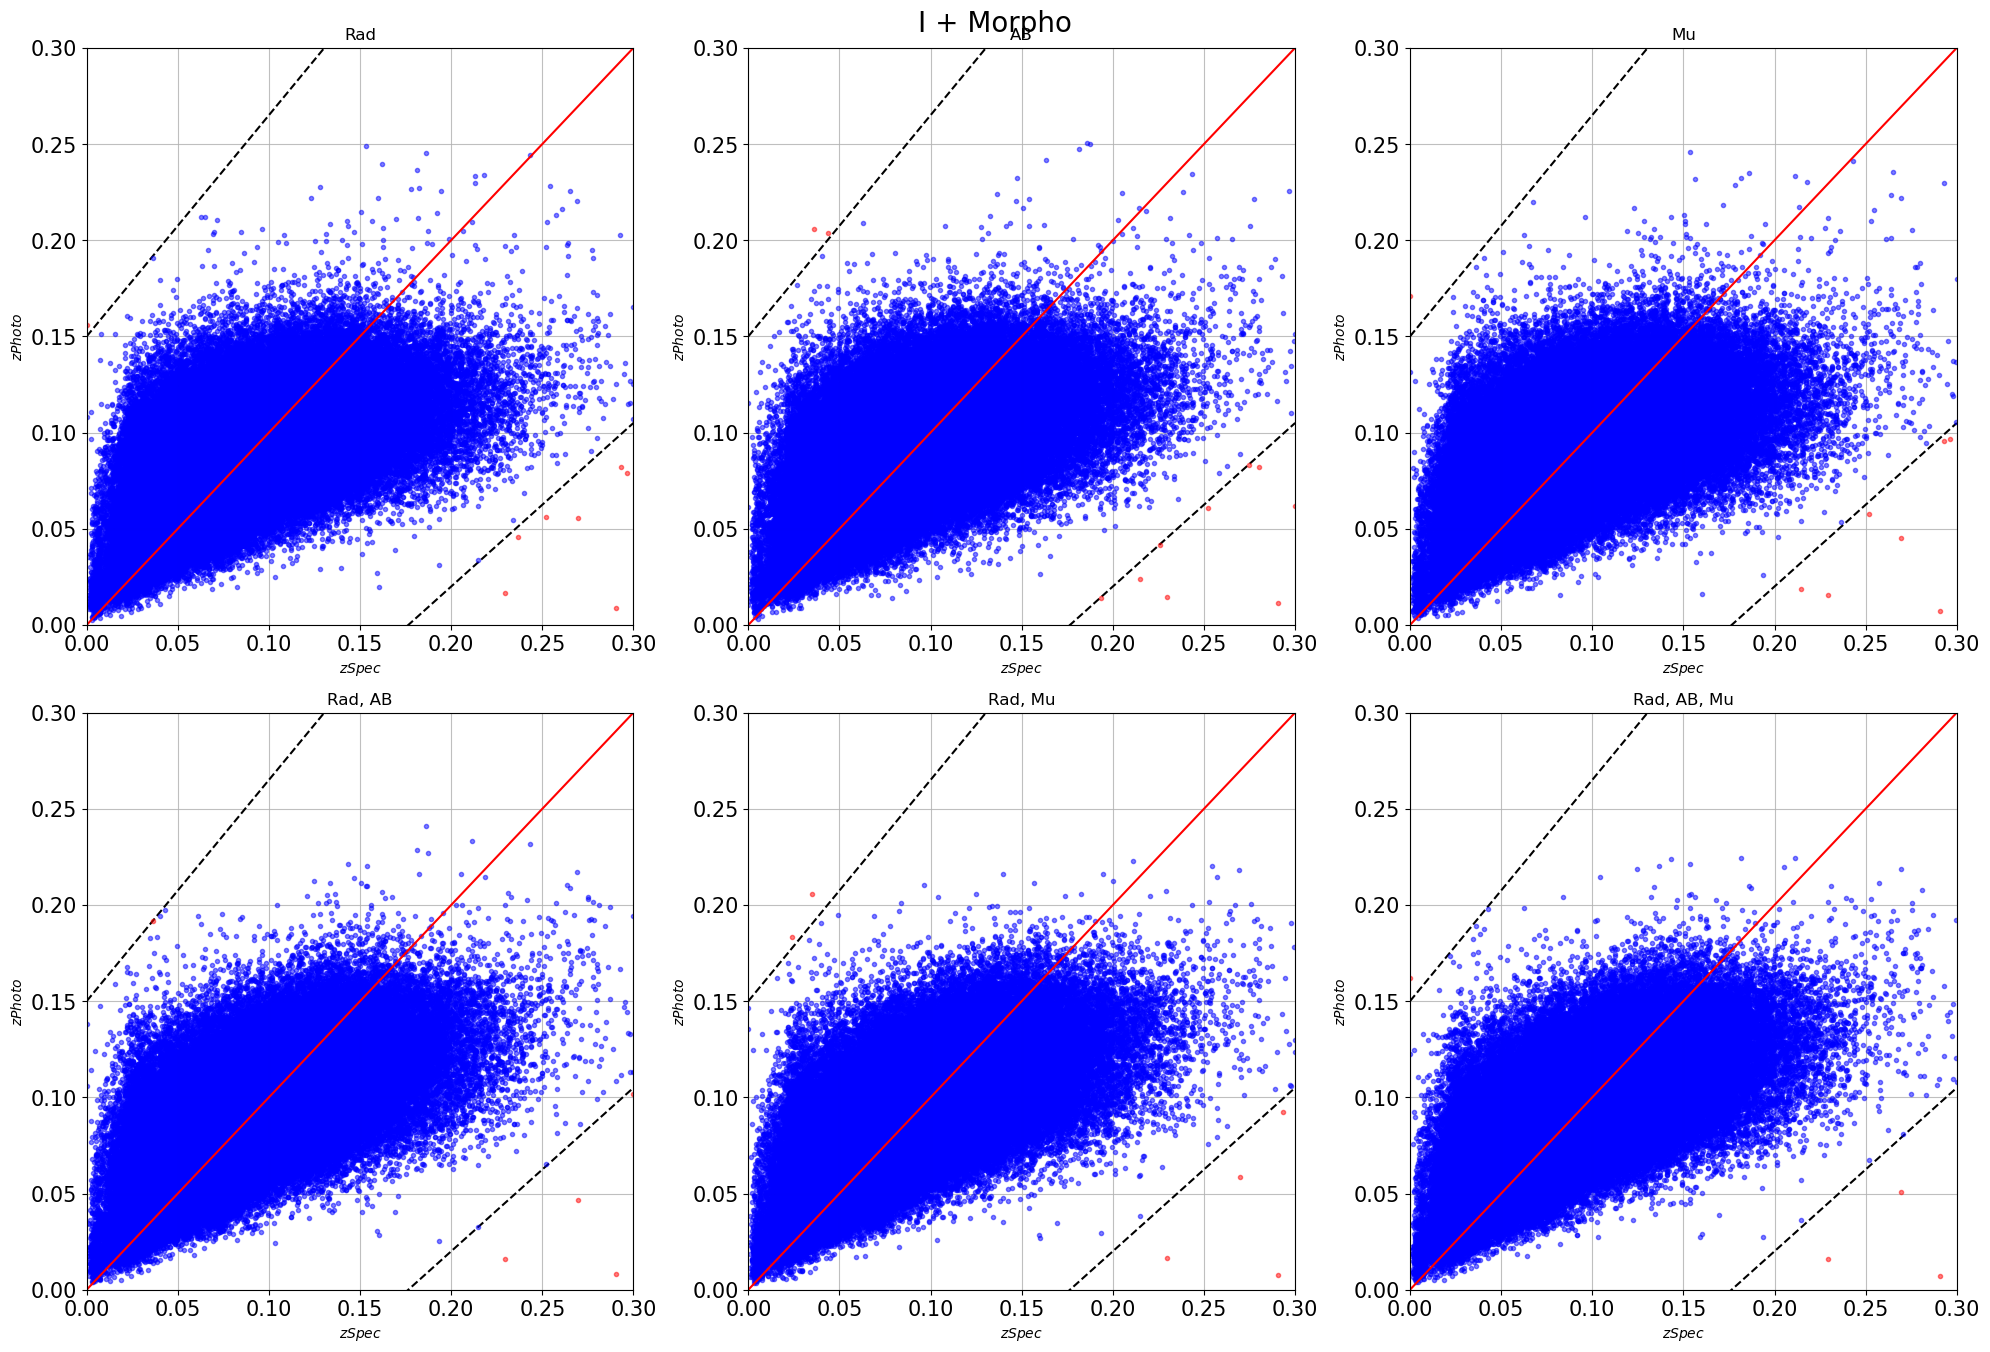

In [41]:
fig, axs = plt.subplots(3, 3, figsize=(20,20), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('I + Morpho', fontsize=20)
axs[2,0].set_visible(False)
axs[2,1].set_visible(False)
axs[2,2].set_visible(False)

subplot_PE(0, 0, zSpec_I_R, zPhoto_I_R, zRange=0.3, title='Rad')
subplot_PE(0, 1, zSpec_I_AB, zPhoto_I_AB, zRange=0.3, title='AB')
subplot_PE(0, 2, zSpec_I_Mu, zPhoto_I_Mu, zRange=0.3, title='Mu')
subplot_PE(1, 0, zSpec_I_RA, zPhoto_I_RA, zRange=0.3, title='Rad, AB')
subplot_PE(1, 1, zSpec_I_RM, zPhoto_I_RM, zRange=0.3, title='Rad, Mu')
subplot_PE(1, 2, zSpec_I_RAM, zPhoto_I_RAM, zRange=0.3, title='Rad, AB, Mu')

In [42]:
# initialize list of lists
data = [['-', RMSE_I, Outlier_I, Perc68_I, NMAD_I],
        ['Rad', RMSE_I_R, Outlier_I_R, Perc68_I_R, NMAD_I_R], 
        ['AB', RMSE_I_AB, Outlier_I_AB, Perc68_I_AB, NMAD_I_AB], 
        ['Mu', RMSE_I_Mu, Outlier_I_Mu, Perc68_I_Mu, NMAD_I_Mu], 
        ['Rad,AB', RMSE_I_RA, Outlier_I_RA, Perc68_I_RA, NMAD_I_RA], 
        ['Rad,Mu', RMSE_I_RM, Outlier_I_RM, Perc68_I_RM, NMAD_I_RM], 
        ['Rad,AB,Mu', RMSE_I_RAM, Outlier_I_RAM, Perc68_I_RAM, NMAD_I_RAM]]

# Create the pandas DataFrame
Summary = pd.DataFrame(data, columns=['I+', 'RMSE', 'Outlier', '68th', 'NMAD'])
print(Summary)

          I+      RMSE   Outlier      68th      NMAD
0          -  0.040206  0.068888  0.018358  0.037223
1        Rad  0.030426  0.005567  0.014132  0.026890
2         AB  0.029992  0.007654  0.013981  0.026819
3         Mu  0.030530  0.005567  0.014061  0.026924
4     Rad,AB  0.028134  0.003479  0.012642  0.024471
5     Rad,Mu  0.027909  0.004175  0.012510  0.024165
6  Rad,AB,Mu  0.027879  0.002783  0.012525  0.024203


Text(0, 0.5, 'NMAD')

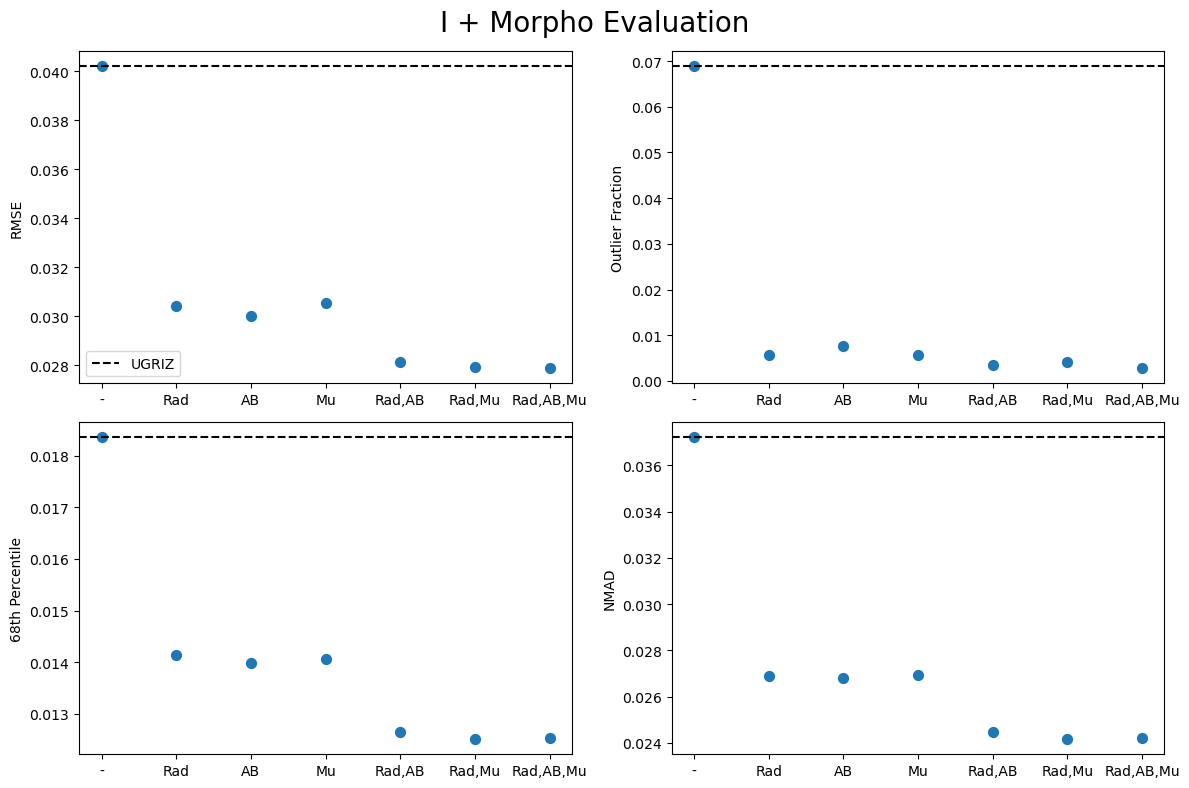

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(12,8), tight_layout=True, sharex=False, sharey=False)
fig.suptitle('I + Morpho Evaluation', fontsize=20)
axs[0,0].axhline(y = RMSE_I, color = 'k', linestyle = '--', label='UGRIZ')
axs[0,0].scatter(Summary['I+'], Summary['RMSE'], s=50)
axs[0,0].legend(loc='lower left')
axs[0,0].set_ylabel('RMSE')

axs[0,1].axhline(y = Outlier_I, color = 'k', linestyle = '--')
axs[0,1].scatter(Summary['I+'], Summary['Outlier'], s=50)
axs[0,1].set_ylabel('Outlier Fraction')

axs[1,0].axhline(y = Perc68_I, color = 'k', linestyle = '--')
axs[1,0].scatter(Summary['I+'], Summary['68th'], s=50)
axs[1,0].set_ylabel('68th Percentile')

axs[1,1].axhline(y = NMAD_I, color = 'k', linestyle = '--')
axs[1,1].scatter(Summary['I+'], Summary['NMAD'], s=50)
axs[1,1].set_ylabel('NMAD')

END